# 0.0 Imports

In [374]:
import matplotlib.pyplot as plt
import seaborn           as sns
import pandas            as pd
import numpy             as np

import xgboost as xgb
import inflection
import datetime
import warnings
import math

from statsmodels.stats.multicomp  import pairwise_tukeyhsd
from scipy.stats                  import f_oneway, chi2_contingency
from matplotlib.gridspec          import GridSpec
from IPython.display              import Image
from tabulate                     import tabulate
from sklearn.preprocessing        import RobustScaler, MinMaxScaler
from sklearn.preprocessing        import LabelEncoder
from sklearn.preprocessing        import OneHotEncoder
from sklearn.feature_selection    import SelectKBest, f_classif, f_regression
from sklearn.model_selection      import train_test_split
from sklearn.compose              import ColumnTransformer
from sklearn.metrics              import mean_absolute_error, mean_squared_error
from sklearn.linear_model         import LinearRegression, Lasso, Ridge
from sklearn.ensemble             import RandomForestRegressor


In [2]:
warnings.filterwarnings("ignore")
plt.style.use('ggplot')
pd.set_option('display.max_columns', None)

## 0.1 Helper Functions

In [368]:
def cramer_v(data, x, y):
    cm = pd.crosstab(data[x], data[y]).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n)/(min(kcorr-1, rcorr-1)))


def get_categorical_corr(data):
    categorical_corr = {}
    columns = data.columns

    for i in columns:
        categorical_corr[i] = []
        for j in columns:
            categorical_corr[i].append(cramer_v(data, i, j))

    return categorical_corr


def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs((y-yhat)/y))


def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse}, index=[0])


def cross_validation(model_name, model, X_train_cv, kfold):

    cv_df = pd.DataFrame()
    k_list = []

    for k in reversed(range(1, kfold+1)):
        print(f'KFold: {k}')
        k_list.append(k)

        validation_start_date = X_train_cv['date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date = X_train_cv['date'].max() - datetime.timedelta(days=(k-1)*6*7)

        training = X_train_cv[X_train_cv['date'] < validation_start_date]
        validation = X_train_cv[(X_train_cv['date'] >= validation_start_date) & (X_train_cv['date'] <= validation_end_date)]

        y_training = training['sales']
        x_training = training.drop(['sales', 'date'], axis=1)

        y_validation = validation['sales']
        x_validation = validation.drop(['sales', 'date'], axis=1)

        #model
        m = model.fit(x_training, y_training)

        #predict
        y_pred = m.predict(x_validation)

        #perfomance
        m_metrics = ml_error(model_name, np.expm1(y_validation), np.expm1(y_pred))
        m_metrics

        cv_df = pd.concat([cv_df, m_metrics], axis=0)
        cv_df = cv_df.reset_index(drop=True)

    cv_df['k'] = pd.Series(k_list)
    
    metrics = ['MAE', 'MAPE', 'RMSE']
    m_results = {}

    for metric in metrics:
        m_results[metric] = np.round(np.mean(cv_df[metric]), 2).astype(str) + ' +/- ' + np.round(np.std(cv_df[metric]), 2).astype(str)
        
    df_cv_metrics = pd.DataFrame(m_results, index=[0])
    df_cv_metrics['Model'] = model_name
    
    return df_cv_metrics

## 0.2 Loading data

In [5]:
#dataset que contém dados das vendas
df_sales_raw = pd.read_csv('../data/train.csv', low_memory=False)

#dataset que contém dados das lojas
df_stores_raw = pd.read_csv('../data/store.csv', low_memory=False)

#dataset final
df_raw = pd.merge(df_sales_raw, df_stores_raw, how='left', on='Store')

In [6]:
df_sales_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [7]:
df_stores_raw.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [8]:
df_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


# 1.0 Descrição e limpeza dos dados

## Qual é a motivação por trás dessa tarefa?

Descobrir o quão desafiador é o problema.

* É preciso saber a quantidade de dados:
    * eu tenho recursos corretos para trabalhar?
    * preciso de servidores? clusters? ferramentas para trabalhar com esses dados, como spark e hadoop?
    
* Tipos de variáveis:
    * quais os tipos de variáveis? % de numéricas, categóricas e temporais.
    
* Quantidade de dados faltantes:
    * qual o volume de dados NA?
    * qual a razão de faltar dados? é o sistema? input manual?
    
* Resumo geral dos dados:
    * estatística descritiva - importante para ter uma noção dos dados. dos limites máximos e mínimos..

## Data Dictionary

* Id - an Id that represents a (Store, Date) duple within the test set
* Store - a unique Id for each store
* Sales - the turnover for any given day (this is what you are predicting)
* Customers - the number of customers on a given day
* Open - an indicator for whether the store was open: 0 = closed, 1 = open
* StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
* SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
* StoreType - differentiates between 4 different store models: a, b, c, d
* Assortment - describes an assortment level: a = basic, b = extra, c = extended
* CompetitionDistance - distance in meters to the nearest competitor store
* CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
* Promo - indicates whether a store is running a promo on that day
* Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
* Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
* PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

## 1.1 Rename Columns

In [9]:
df1 = df_raw.copy()

É importante para criar um padrão nos nomes da coluna, além de renomear colunas que possuem nomes que não fazem muito sentido ou que são muito extensos. Isso facilita todo o desenvolvimento. Nesse ambiente do Kaggle e de datasets de estudo, as colunas já vem melhor nomeadas. Mas no contexto real nem sempre é assim. Por isso é uma boa prática realizar essa etapa.

In [10]:
#colunas antigas
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 
            'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

#função para alterar o nome das colunas para o formato snakecase
change_to_snakecase = lambda x: inflection.underscore(x)

#aplicando a função nas colunas antigas
new_cols = list(map(change_to_snakecase, cols_old))

#renomeando as colunas
df1.columns = new_cols

#verificando os novos nomes
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2 Data dimension

In [11]:
shape = df1.shape
print(f'Number of rows: {shape[0]}')
print(f'Number of columns: {shape[1]}')

Number of rows: 1017209
Number of columns: 18


## 1.3 Data types

In [12]:
#alterando o tipo da coluna date para datetime (estava como object)
df1['date'] = pd.to_datetime(df1['date'])

df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Verificação de dados faltantes

In [13]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Substituição dos dados faltantes

Existem basicamente três maneiras para lidar com dados faltantes:
1. Eliminar as linhas que possuem NA
    * Vantagem: rápido e fácil
    * Desvantagem: pode desperdiçar dados
    
    
2. Substituir os faltantes por métricas (média, mediana...) ou por previsão de algoritmos


3. Conhecendo do negócio e entendendo por que esses NAs estão aí


##### competition_distance

É a distância em metros até a loja concorrente mais próxima.

* Hipótese: se esse valor está nulo, é porque não há competidor próximo. O concorrente está muito longe.

  Assumindo essa hipótese, substituirei os nulos dessa coluna por um 3x maior que o maior valor da coluna. 

In [14]:
max_value = df1['competition_distance'].max()
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: max_value*3 if math.isnan(x) else x)

#### competition_open_since_month & competition_open_since_year 

Dá aproximadamente o ano e o mês em que o competidor mais próximo foi aberto.

Pensando no negócio, essa coluna pode estar nula basicamente por duas razões:
1. Não existe um competidor próximo.
2. Existe um competidor mas alguém esqueceu de anotar, ou porque abriu muito antes ou muito depois.

Hipótese: Irei optar por manter essa coluna pois acredito que ela deve inlfuenciar nos resultados, já que o fato de uma loja possuir um competidor próximo ou não impacta diretamente nas vendas. Ainda mais nos casos em que temos um valor preenchido para 'competition_distance', não faria sentido colocar 0 para a 'competition_open_since_month' e 'competition_open_since_year', já que está sendo afirmado que existe um competidor.

Para preencher a coluna, então, pegarei o mês e o ano da linha em questão.

In [15]:
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

#### promo2_since_week & promo2_since_year

Descreve o ano e a semana do calendário quando a loja começou a participar da Promo2. A Promo2 é a continuação de uma primeira promoção (0 se não participar dessa continuação e 1 se participou).

Para a substituição dos faltantes nessa coluna, seguirei a mesma lógica das colunas 'competition_open_since_month' e 'competition_open_since_year'.

In [16]:
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

#### promo_interval              

Descreve os intervalos consecutivos que a Promo2 começou, nomeando os meses que a promoção ficou ativa. Por exemplo, "Feb, May, Aug, Nov" significa que cada round começou em Fevereiro, depois de novo em Maio, Agosto e Novembro do ano descrito para a loja específica.

* Caso o campo dessa coluna esteja nulo, será substituído por 0, indicando que não foi feita continuação da Promo2.

In [17]:
#diicionário para mapear os meses
month_map = {
    1:'Jan',
    2:'Feb',
    3:'Mar',
    4:'Apr',
    5:'May',
    6:'Jun',
    7:'Jul',
    8:'Aug',
    9:'Sept',
    10:'Oct',
    11:'Nov',
    12:'Dec'
}

#preenche os nulos com 0
df1['promo_interval'].fillna(0, inplace=True)

#cria uma coluna 'month_map' com o nome dos meses
df1['month_map'] = df1.date.dt.month.map(month_map)

#cria uma coluna 'is_promo' que indica se no mês do registro teve Promo2 ou não
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

### 1.5.1 Verificando de novo os Data Types

In [18]:
# competition_open_since_month
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)

# competition_open_since_year 
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

# promo2_since_week           
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)

# promo2_since_year           
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

In [19]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int32
competition_open_since_year              int32
promo2                                   int64
promo2_since_week                        int32
promo2_since_year                        int32
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.6 Estatística Descritiva 

A estatística descritiva é útil por, basicamente, duas razões:

1. Por meio dela é possível ganhar conhecimento de negócio:
    * Métricas de dispersão (saber o quão esparso os dados estão em torno da média)
    * Métricas de tendência central (resumem os dados em um único número)
    
    
2. Detecção de erros
    * Por ex, se tiver um valor de vendas negativo, isso não faz sentido nenhum

### 1.6.1 Separação em atributos numéricos e categóricos

In [20]:
#separação das colunas em categóricas e numéricas

num_attributes = df1.select_dtypes(include=['int64', 'int32', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'int32', 'float64', 'datetime64[ns]'])

In [21]:
display(num_attributes.sample())
display(cat_attributes.sample())

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
302210,453,3,7395,948,1,1,1,75860.0,10,2014,0,43,2014,0


,state_holiday,store_type,assortment,promo_interval,month_map
299441,0,d,a,"Jan,Apr,Jul,Oct",Oct


### 1.6.2 Atributos numéricos

<b> Medidas de tendência central </b>

In [22]:
central_tendency = num_attributes.describe().loc[["mean", "50%"]].T
central_tendency.columns = ['mean', 'median']

<b> Medidas de dispersão </b>

In [23]:
dispersion = num_attributes.describe().loc[['min', 'max', 'std']].T
dispersion['range'] = dispersion[['min', 'max']].apply(lambda x: x['max'] - x['min'], axis=1)
dispersion['skewness'] = num_attributes.apply(lambda x: x.skew())
dispersion['kurtosis'] = num_attributes.apply(lambda x: x.kurtosis())

<b> Concatenação das medidas de tendência central e dispersão </b>

In [24]:
descriptive_statistics = pd.concat([central_tendency, dispersion], axis=1)
descriptive_statistics = descriptive_statistics.reset_index()
descriptive_statistics.rename(columns={'index': 'attributes'}, inplace=True)
descriptive_statistics[['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skewness', 'kurtosis']]

,attributes,min,max,range,mean,median,std,skewness,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908651,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997391,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.926175,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411734,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485759,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,227580.0,227560.0,6007.076294,2330.0,13682.735149,11.512969,177.136255
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311087,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515593,-7.235657,124.071304


<b> Alguns insights </b>

'sales'
* não existem vendas negativas, o que dá uma primeira impressão de ausência de erros na inserção desses dados.
* a explicação para vendas igual a 0 é de que a loja estava fechada no momento em que isso foi analisado. 
* a média e mediana são bem parecidas, ou seja, essa distribuição não é tão distoante da normal, o que é visto também pela skew bem próxima de zero e a kurtosis de 1.77, que mostra que não existe um pico muito grande.

[]

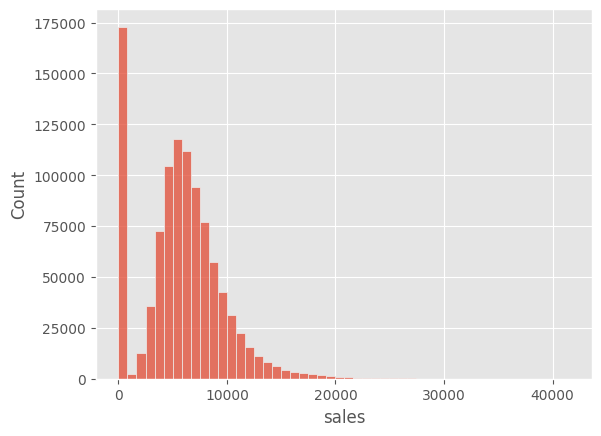

In [25]:
sns.histplot(df1['sales'], bins=50)
plt.plot()

'competition_distance'

* skew positiva alta --> alto deslocamento dos dados para a esquerda, dados concentrados à esquerda
* kurtosis positiva muito alta --> existe um pico muito grande, os dados estão bem concentrados ao redor da média

[]

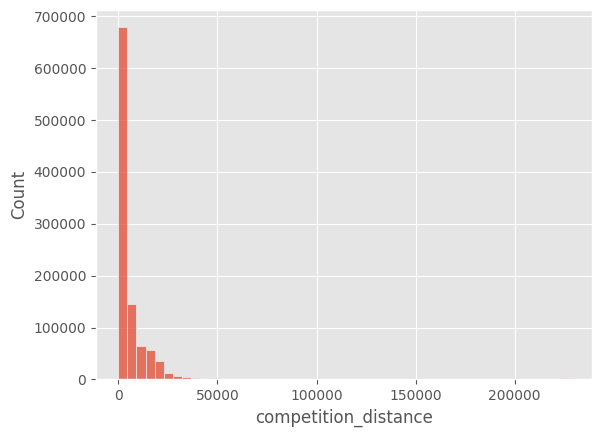

In [26]:
sns.histplot(df1['competition_distance'], bins=50)
plt.plot()

'customers'

* média de 633 clientes por dia circulando nas lojas, com désvio padrão de 464, então as vezes tem 1000 pessoas, as vezes 200.
* skew positiva de 1.6 --> dados concentrados a esquerda (cauda formada à direita), mas não tão concentrados. A média é maior que a mediana, isso significa que há mais dias em que circula um número de clientes abaixo da média.
* kurtosis positiva de 7 --> existe um pico nos dados e estão concentrados ao redor da média

[]

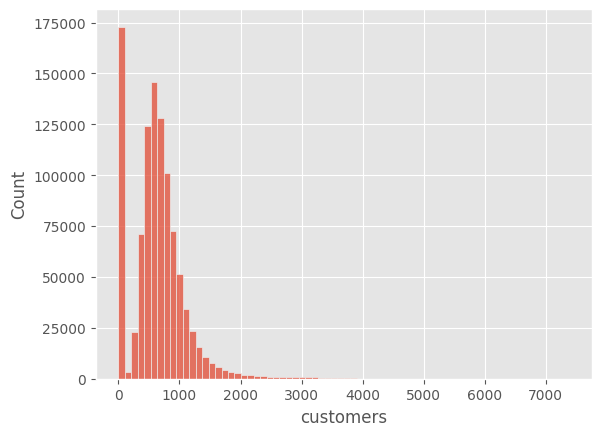

In [27]:
sns.histplot(df1['customers'], bins=70)
plt.plot()

### 1.6.3 Atributos categóricos

In [28]:
#quantos únicos cada coluna tem
cat_attributes.apply(lambda x: x.nunique())

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

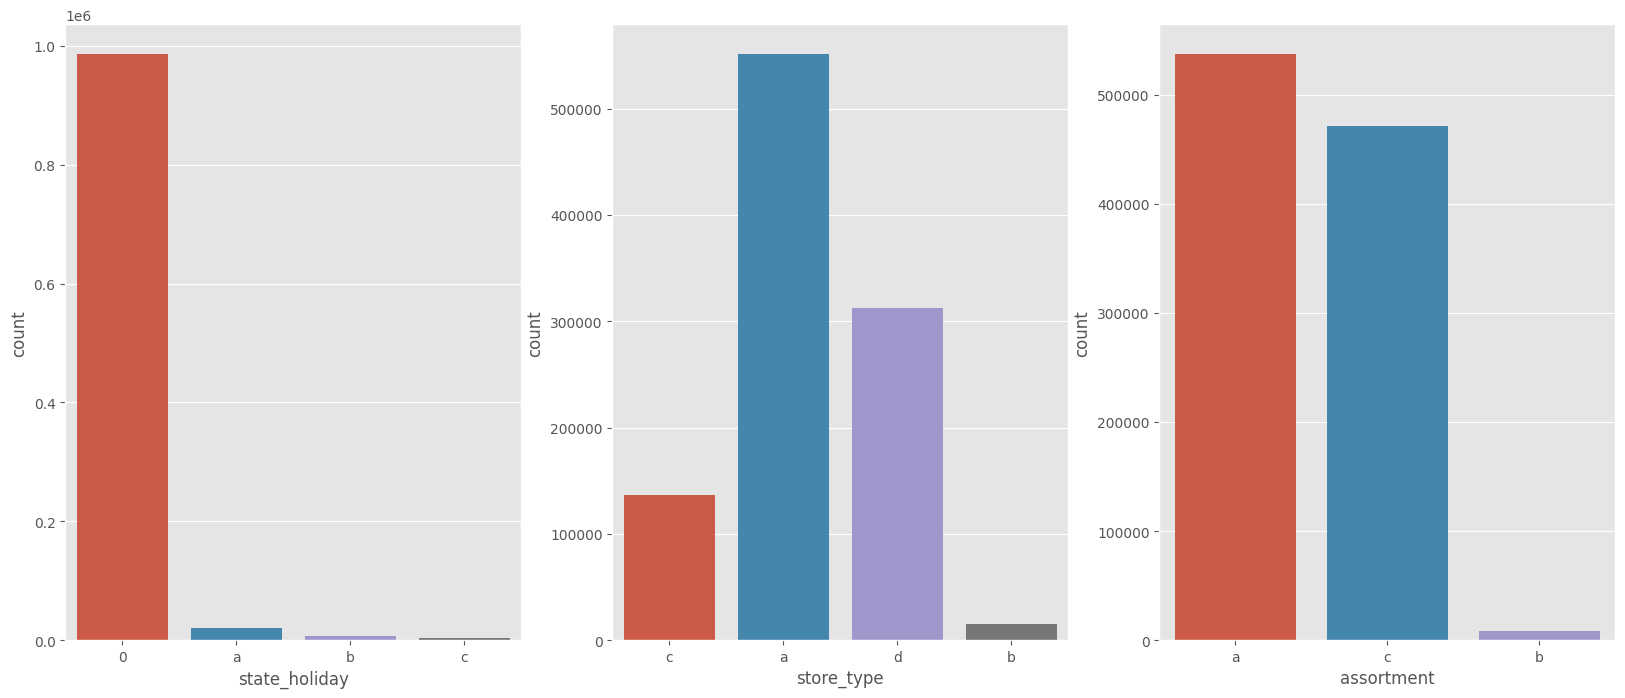

In [29]:
#quanto tem de cada categoria
plt.figure(figsize=(20, 8))

plt.subplot(1, 3, 1)
sns.countplot(data=df1, x='state_holiday')

plt.subplot(1, 3, 2)
sns.countplot(data=df1, x='store_type')

plt.subplot(1, 3, 3)
sns.countplot(data=df1, x='assortment')

plt.show()

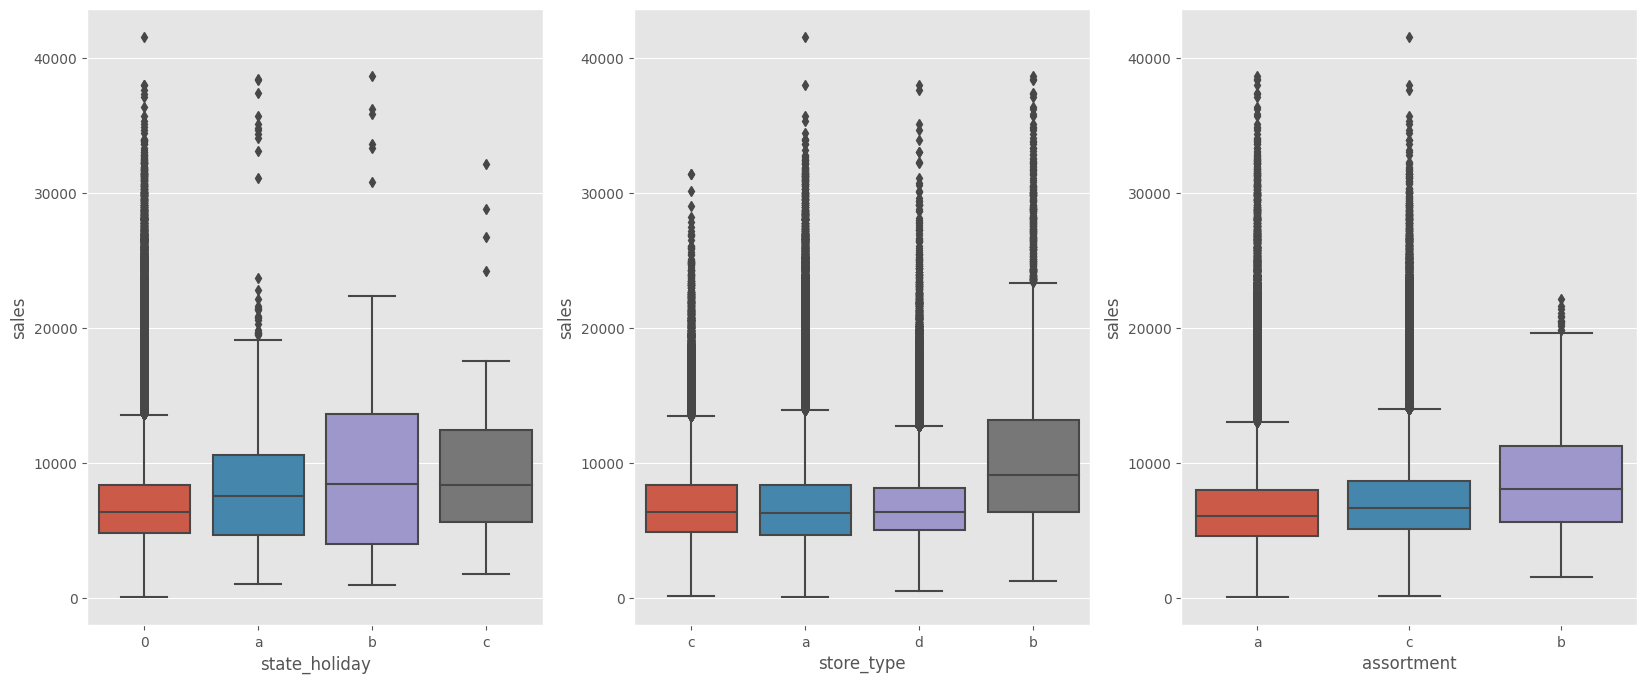

In [30]:
#comparação entre as vendas e 'state_holiday', 'assortment' e 'store_type'
aux = df1[(df1['state_holiday'] != 0) & (df1['sales'] > 0)]

plt.figure(figsize=(20, 8))

plt.subplot(1, 3, 1)
sns.boxplot(data=aux, x='state_holiday', y='sales')

plt.subplot(1, 3, 2)
sns.boxplot(data=aux, x='store_type', y='sales')

plt.subplot(1, 3, 3)
sns.boxplot(data=aux, x='assortment', y='sales')

plt.show()

# 2.0 Feature Engineering

## Qual é a motivação por trás dessa tarefa?

É preciso realizar essa tarefa para possuir as variáveis disponíveis para estudo durante a análise exploratória de dados.

Isso ajuda também a tornar o código mais limpo e mais dividido, para evitar de criar as variáveis durante a análise exploratória de dados e daí misturar duas etapas em uma só.

Mas como saber quais variáveis devo tentar derivar se não explorei os dados? Isso é feito por meio do mindmap de hipóteses.

## 2.1 Mindmap de hipóteses

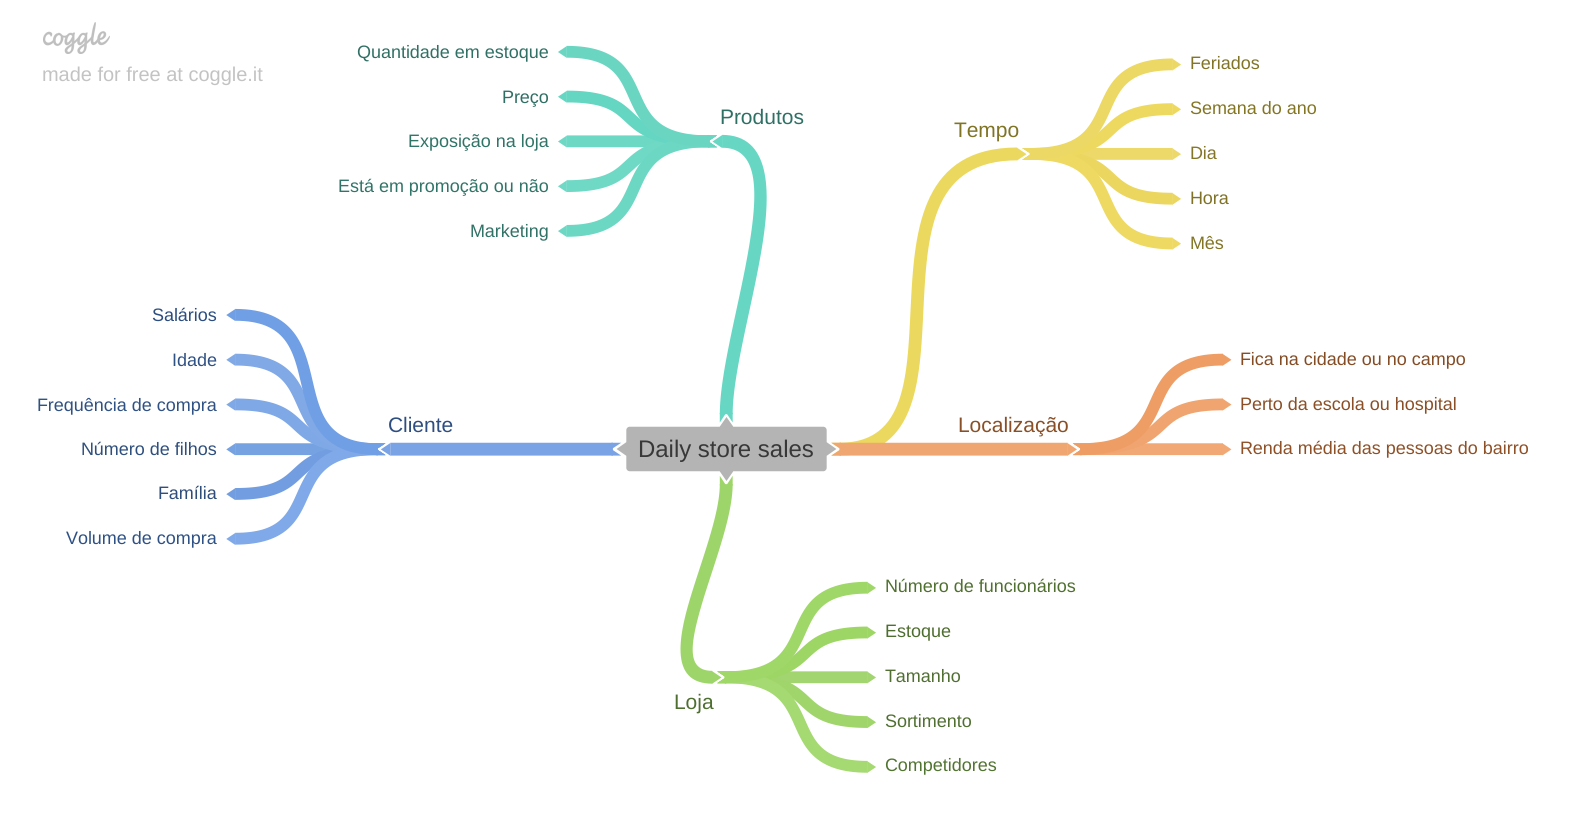

In [31]:
Image('../notes/mindmap_de_hipóteses.png')

## 2.2 Criação das hipóteses

A partir do mindmap acima, conseguimos relacionar os atributos dos agentes com o comportamento de nosso fenômeno, assim, é possível criar as hipóteses para validarmos na análise exploratória dos dados.

Sempre tendo em mente duas coisas:
* Hipóteses são apostas. São suposições sobre como os agentes influenciam no fenômeno modelado.
* Validando ou negando nossas hipóteses nós descobrimos relações de correlação entre variáveis e não de causa e efeito. Se eu descobrir que lojas maiores vendem mais, não dá para simplesmente sair construindo mais lojas.

### 2.2.1 Hipóteses relacionadas ao Produto

**1.** Lojas com produtos com preços menores deveriam vender mais.

**2.** Lojas com produtos em promoção por mais tempo deveriam vender mais.

**3.** Lojas que investem mais em marketing deveriam vender mais.

**4.** Lojas com mais promoções consecutivas deveriam vender mais.

**5.** Lojas com maior exposição dos produtos deveriam vender mais.

### 2.2.2 Hipóteses relacionadas as lojas

**1.** Lojas com mais funcionários deveriam vender mais.

**2.** Lojas com um estoque maior deveriam vender mais.

**3.** Lojas maiores (em tamanho) deveriam vender mais.

**4.** Lojas com mais sortimento deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas mais novas (abertas nos últimos 6 meses) deveriam vender mais.

### 2.2.3 Hipóteses relacionadas ao Tempo

**1**. Lojas abertas durante o feriado de Natal deveriam vender mais.

**2**. Lojas deveriam vender mais ao longo dos anos.

**3**. Lojas deveriam vender mais no segundo semestre do ano.

**4**. Lojas deveriam vender mais depois do dia 10 de cada mês.

**5**. Lojas deveriam vender menos aos finais de semana.

**6**. Lojas deveriam vender menos durante os feriados escolares

## 2.3 Lista final de hipóteses

A partir das hipóteses selecionadas acima, priorizamos elas e criamos essa lista final de hipóteses a serem avaliadas. Essa priorização é feita com base em um critério: "temos os dados disponíveis para responder a hipótese X?". É importante lembrar que o CRISP-DS é uma metodologia de desenvolvimento iterativa. Portanto, neste primeiro ciclo validaremos as hipóteses as quais temos dados disponíveis, mas caso verificarmos que essas variáveis não estão fazendo o modelo performar bem, temos de voltar a etapa inicial de coleta dos dados e buscar por novas fontes de dados.

**1**. Lojas com maior sortimentos deveriam vender mais.

**2**. Lojas com competidores mais próximos deveriam vender menos.

**3**. Lojas com competidores à mais tempo deveriam vendem mais.

**4**. Lojas com promoções ativas por mais tempo deveriam vender mais.

**5**. Lojas com mais dias de promoção deveriam vender mais.

**7**. Lojas com mais promoções consecutivas deveriam vender mais.

**8**. Lojas abertas durante o feriado de Natal deveriam vender mais.

**9**. Lojas deveriam vender mais ao longo dos anos.

**10**. Lojas deveriam vender mais no segundo semestre do ano.

**11**. Lojas deveriam vender mais depois do dia 10 (dia do pagamento) de cada mês.

**12**. Lojas deveriam vender menos aos finais de semana.

**13**. Lojas deveriam vender menos durante os feriados escolares


## 2.4 Feature Engineering

In [32]:
df2 = df1.copy()

In [33]:
#year
df2['year'] = df2['date'].dt.year

#month
df2['month'] = df2['date'].dt.month

#day
df2['day'] = df2['date'].dt.day

#week_of_year -> semana do ano
df2['week_of_year'] = df2['date'].dt.strftime('%W')

#year_week -> ano-semana do ano
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

#competition_since (formatado o dia que a competição começou no mesmo formato que 'date')
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)

#competition_time_month (tempo em meses desde que a competição começou)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

#promo_since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w'))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)
df2['promo_time_week'] = df2['promo_time_week'].apply(lambda x: 0 if x == -1 else x)

#assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

#state_holiday a = public holiday, b = Easter holiday, c = Christmas, 0 = None
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public holiday' if x == 'a' else 'easter holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

# 3.0 Filtragem de Variáveis

## Qual é a motivação por trás dessa tarefa?

Considerar as restrições de negócio.

Muitas vezes um projeto é feito e na hora de colocar o projeto em produção percebe-se que isso não será possível, pois as restrições de negócio não foram consideradas.

Então o ideal é já pensar nessas restrições logo no início do projeto.

Outro ponto, é a diferença entre **filtrar variáveis e selecionar variaveís**.

Filtragem de variáveis:
* Restrições de acordo com o negócio. -> não ter a possibilidade de usar determinada variável.

Seleção de variáveis:
* Variáveis mais relevantes para o modelo.

## 3.1 Filtragem das linhas

Primeiro a gente filtra as linhas, depois seleciona as colunas. Por uma questão de perfomance.. Filtrando as linhas, reduz o volume dos dados e a partir disso seleciona as colunas.

Condições para filtragem das linhas:
    
**1.** Se a coluna 'open' for igual a 0, significa que a loja não estava aberta naquele dia, o que significa que nenhuma venda será feita. Ou seja, não temos aprendizado com isso.

**2.** O valor de vendas deve ser maior do que 0. Queremos modelar aquilo que impacta nas vendas. Se tenho uma linha que tem vendas igual a 0, não consigo aprender nada com ela.

In [34]:
df3 = df2.copy()

In [35]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)] 

## 3.2 Seleção das colunas

Colunas que serão filtradas:

**customers**
* Não é possível ter o número de clientes que terá na loja nas próximas 6 semanas, que é o período que nossa predição será feita. Então, no momento da predição não temos ela.

**open**
* Uma vez que dropamos todas as linhas iguais a 0, só restaram linhas em que open = 1.

**promo_interval**
* Coluna auxiliar para gerar 'is_promo'.

**month_map**
* Coluna auxiliar para gerar 'is_promo'.


In [36]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

# 4.0 Exploratory Data Analysis (EDA)

In [37]:
df4 = df3.copy()

## Qual é a motivação por trás dessa tarefa?

#### Os 3 principais objetivos da EDA

1. Ganhar experiência de negócio


2. Validar hipóteses de negócio e, consequentemente, gerar insights. Para gerar um insight, precisam de duas coisas:
    * Gerar surpresa. Gerar uma informação que as pessoas não sabiam.
    * Gerar uma quebra de crença da pessoa. A pessoa acredita em X e você prova que Y com os dados.
    
 
3. Perceber variáveis que são importantes para o modelo.
    * Entender como as variáveis impactam o fenômeno que está sendo modelado
    * Descobrir qual a força desses impactos 

A respeito do passo 3: existem algoritmos para isso, mas eles não podem ser 100% confiáveis. Você deve julgar se o que ele retornou faz sentido ou não, e para isso você precisa entender essas relações entre as variáveis.

#### Tipos de análises que compõem a EDA

**Análise Univariada**

* Entender como uma variável específica se comporta.
* Entender as métricas estatísticas associadas a ela. (max, min, range...)

**Análise Bivariada**

* Como determinada variável impacta nas respostas
* Correlação, validação de hipóteses...

**Análise Multivariada**

* Olhando a relação entre múltiplas variáveis, tanto entre si, quanto em relação a variável resposta

## 4.1 Análise Univariada

### 4.1.1 Variável Resposta

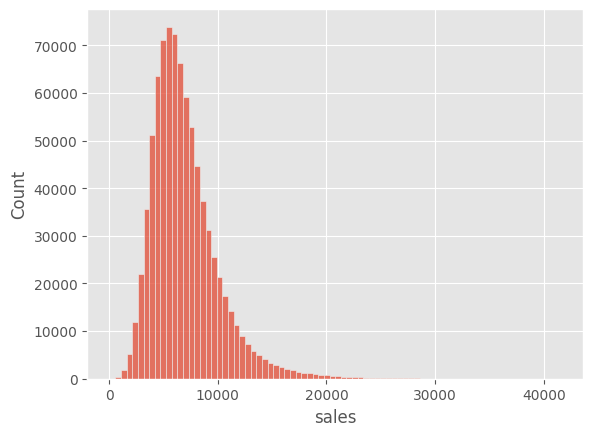

In [38]:
sns.histplot(df4['sales'], bins=80, kde=False)
plt.show()

A distribuição da variável resposta se aproxima bastante de uma normal. Saber disso é importante pois vários modelos de ML possuem como premissa que a distribuição da variável resposta é uma normal, ou algo próximo a ela.

### 4.1.2 Variáveis Numéricas

In [39]:
#separando apenas variáveis numéricas
num_attributes = df4.select_dtypes(include=['int64', 'int32', 'float64'])

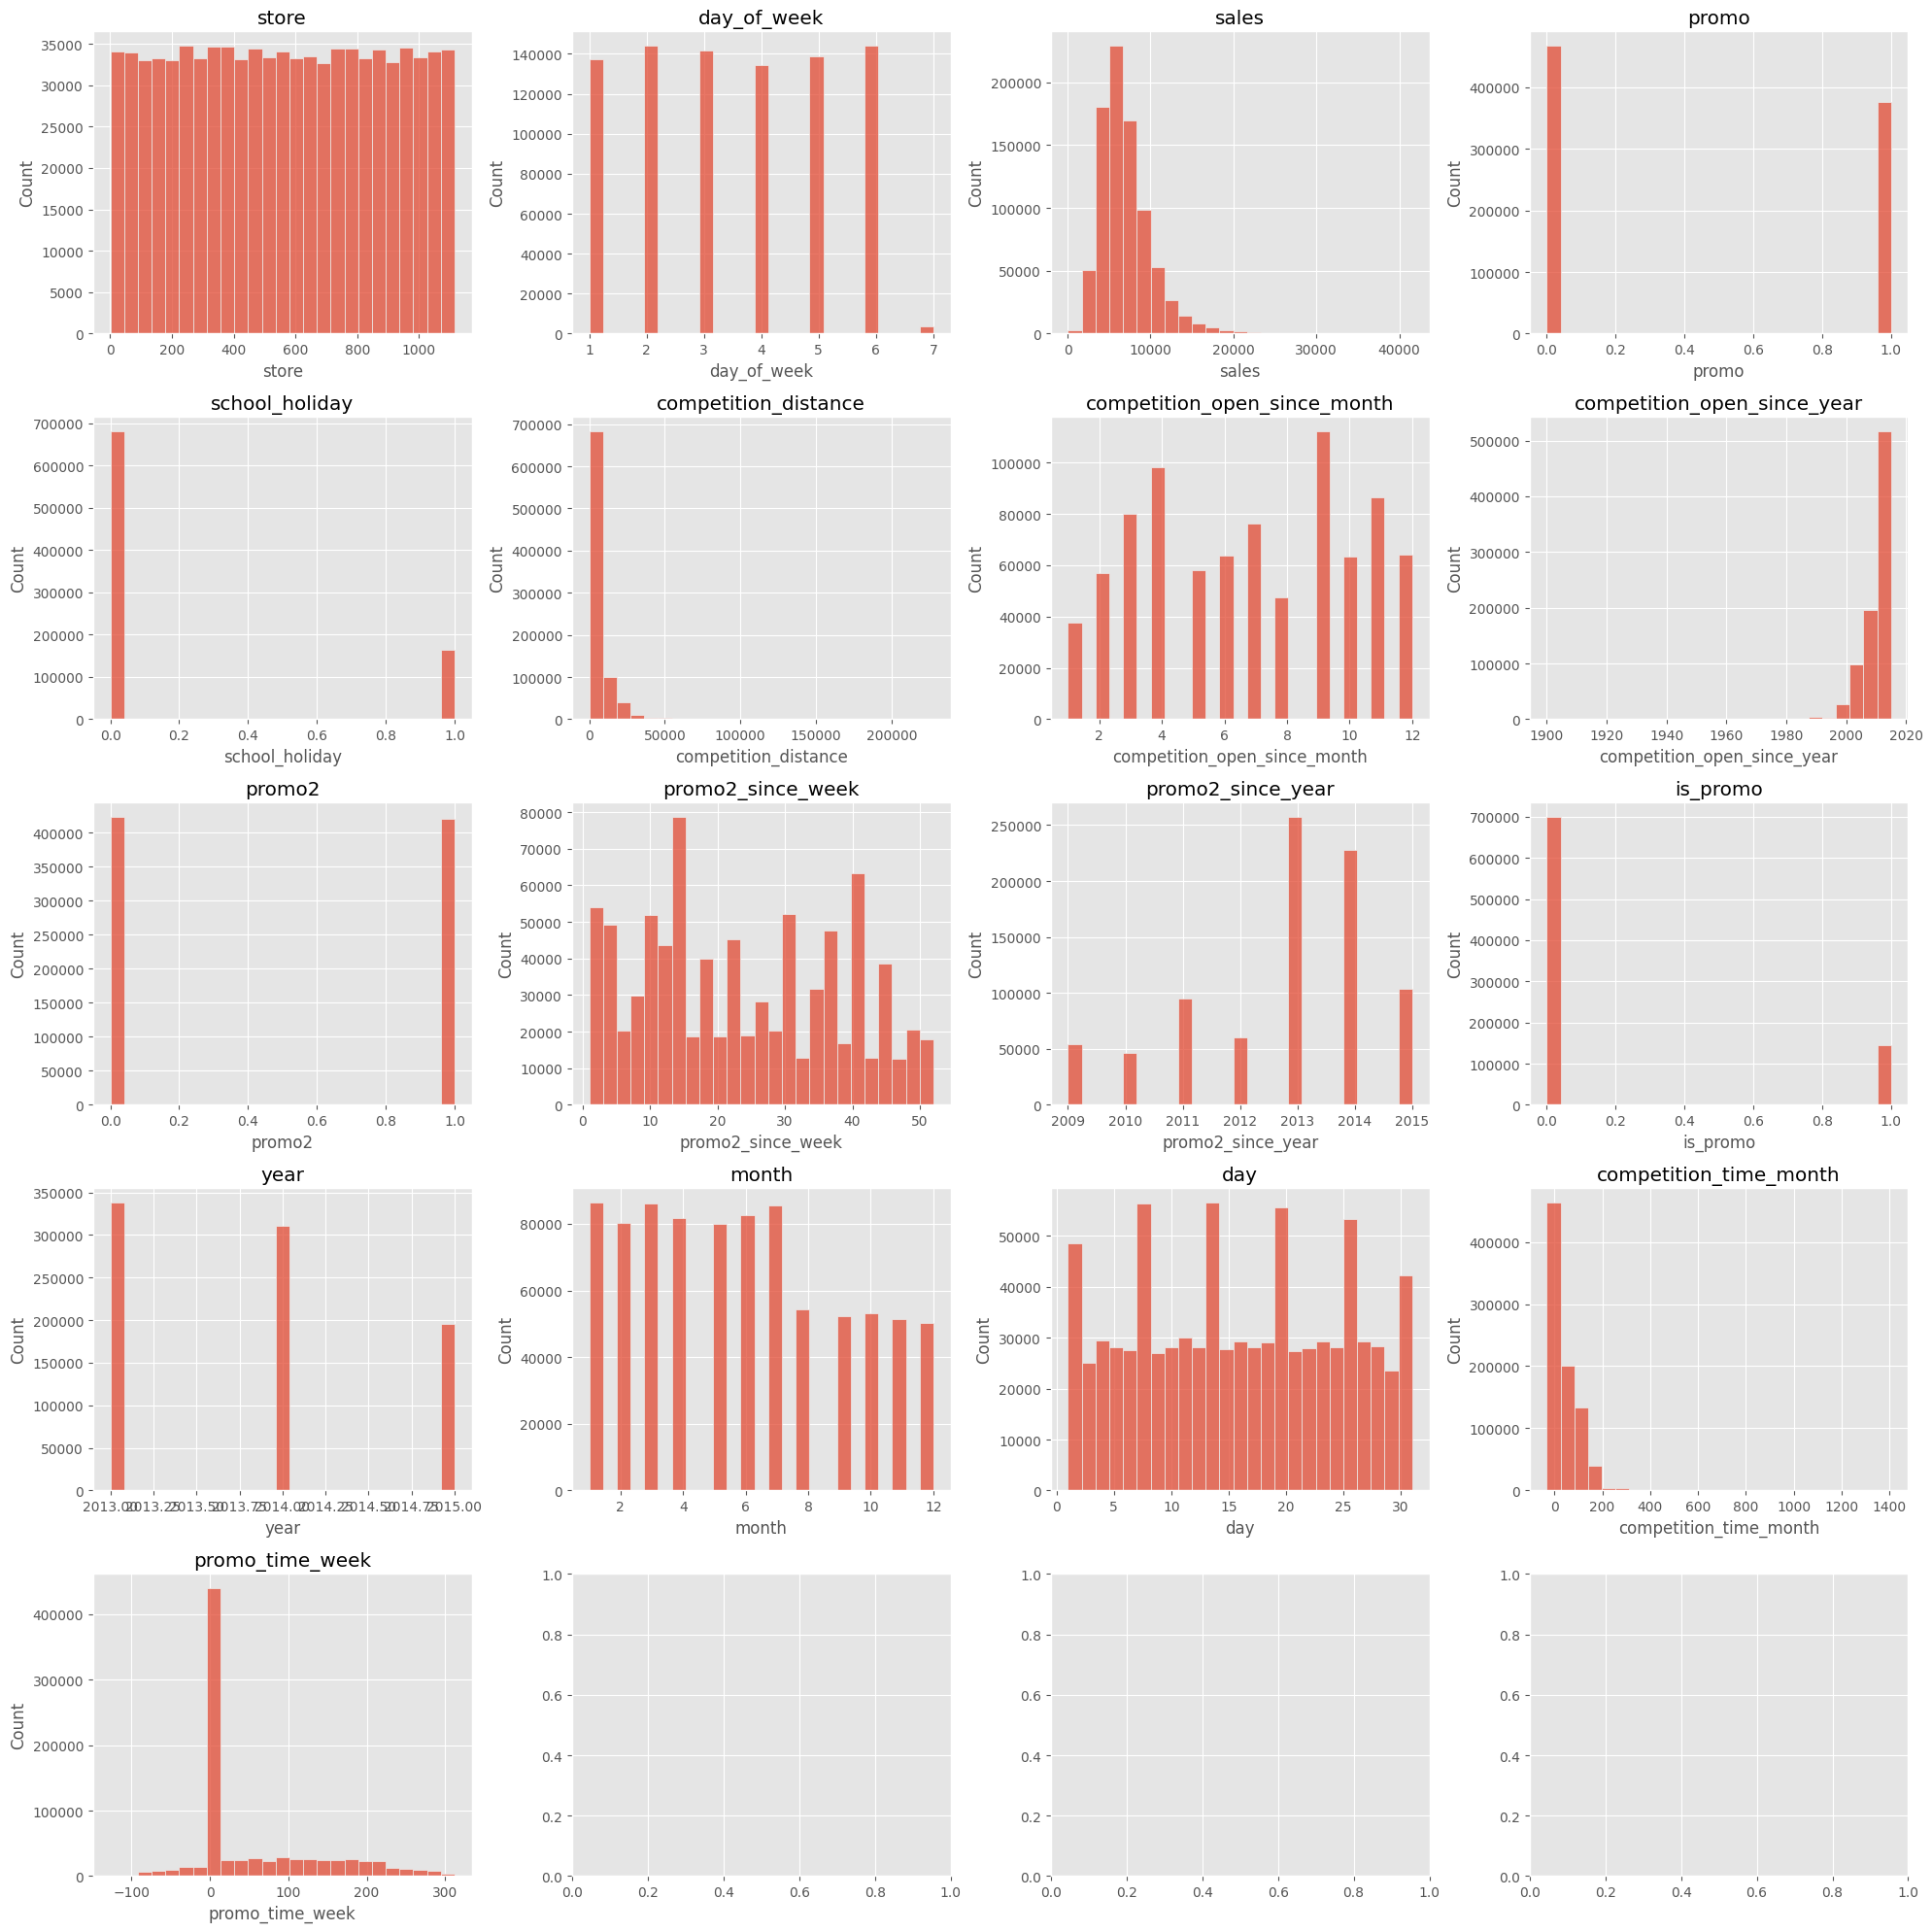

In [40]:
#define o número de linhas e colunas no grid
n_rows = 5
n_cols = 4

#cria o grid de subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 20))

#define o nome das colunas a serem plotadas
columns = num_attributes.columns

#loop para plotar os histogramas
for i, column in enumerate(columns):
    #calcula o índice da linha e coluna no grid
    row = i // n_cols
    col = i % n_cols
    #plota o histograma no subplot correspondente
    sns.histplot(data=num_attributes[column], ax=axs[row, col], bins=25, kde=False)
    axs[row, col].set_title(column)

#ajusta o espaçamento entre os subplots
plt.tight_layout()

#exibe o grid de subplots
plt.show()

### 4.1.3 Variáveis Categóricas

In [41]:
#separando apenas variáveis categóricas
cat_attributes = df4.select_dtypes(exclude=['int64', 'int32', 'float64', 'datetime64[ns]'])

In [42]:
#selecionando as variáveis que serão analisadas
cat_attributes[['state_holiday', 'store_type', 'assortment']].head()

,state_holiday,store_type,assortment
0,regular_day,c,basic
1,regular_day,a,basic
2,regular_day,a,basic
3,regular_day,c,extended
4,regular_day,a,basic


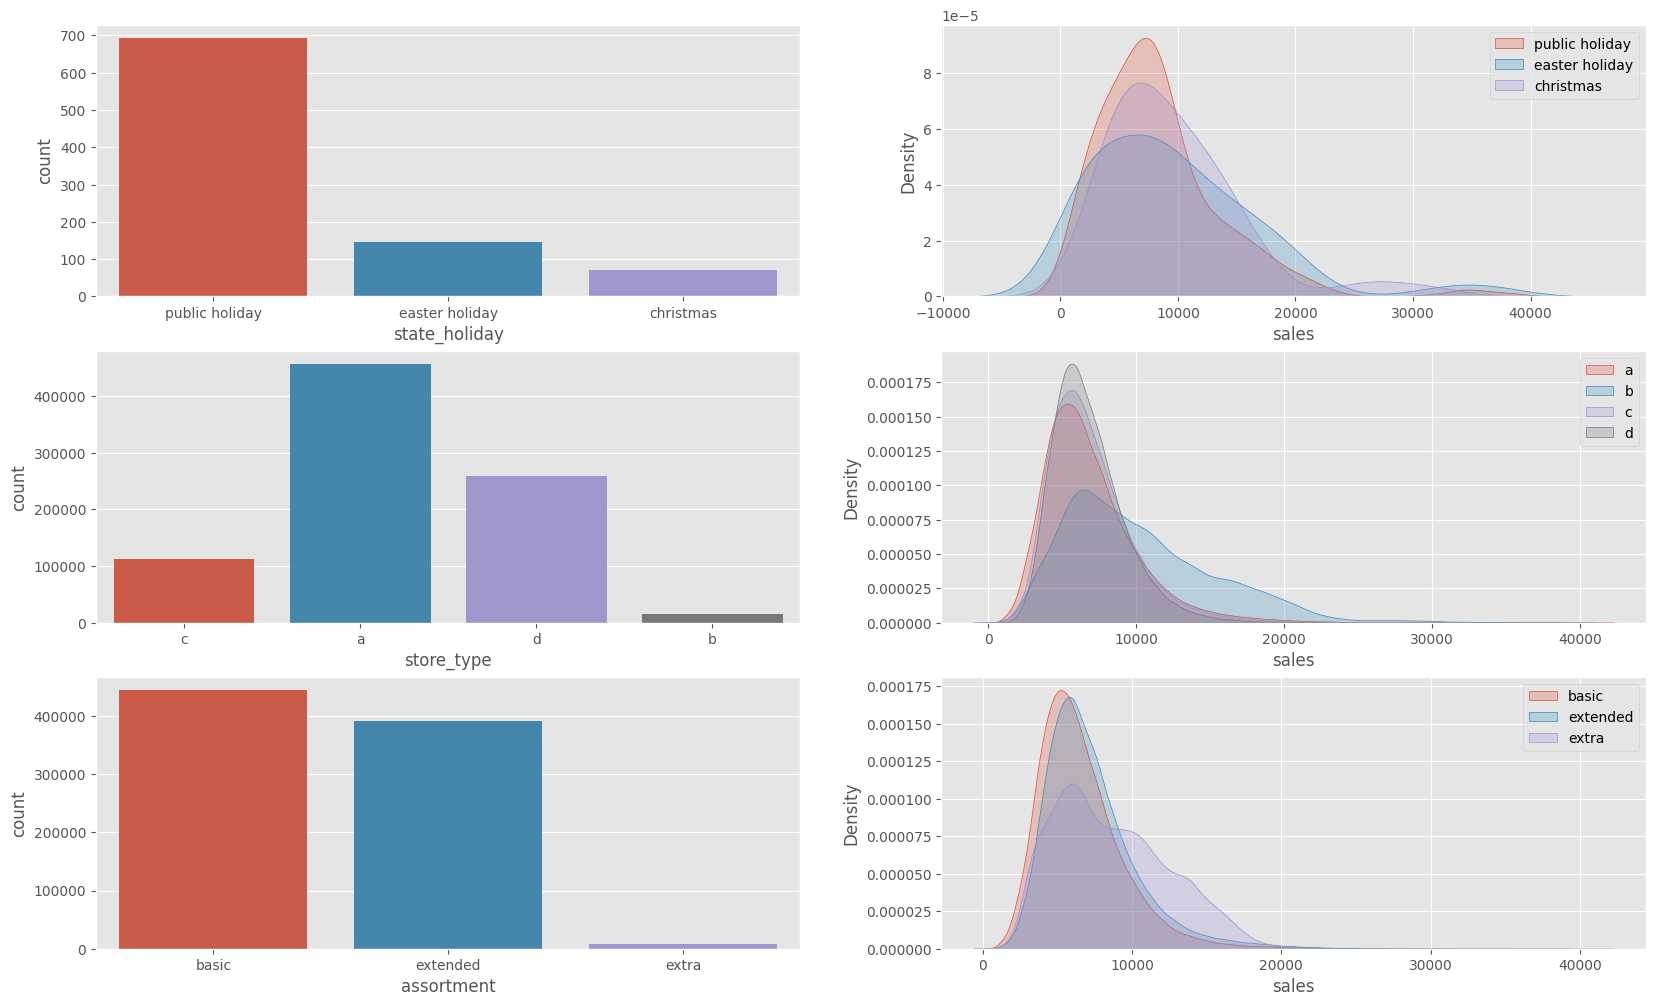

In [43]:
plt.figure(figsize=(20, 12))

#state_holiday
plt.subplot(3, 2, 1)
sns.countplot(data=cat_attributes[cat_attributes['state_holiday'] != 'regular_day'], x='state_holiday')

plt.subplot(3, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'public holiday']['sales'], label='public holiday', fill=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter holiday']['sales'], label='easter holiday', fill=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', fill=True)
plt.legend()

#store_type
plt.subplot(3, 2, 3)
sns.countplot(data=cat_attributes, x='store_type')

plt.subplot(3, 2, 4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', fill=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', fill=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', fill=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', fill=True)
plt.legend()

#assortment
plt.subplot(3, 2, 5)
sns.countplot(data=cat_attributes, x='assortment')

plt.subplot(3, 2, 6)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', fill=True)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', fill=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', fill=True)
plt.legend()

plt.show()

Olhando para os gráficos de 'state_holiday':

* Existem menos ocorrências de christmas em relação a eater holidays.
* Mesmo com o fato acima, ao olhar o KDE Plot de christmas e de easter, vemos que no intervalo de vendas de R$50k a R$100k há mais chance de ocorrência de vendas nessa faixa para os dias de natal. Isso mostra que essas variáveis são importantes.

Olhando para 'store_type':

* As vendas mais altas ocorrem em lojas do tipo b

## 4.2 Análise Bivariada

#### Hipóteses que serão validadadas

1. Lojas com maior sortimentos deveriam vender mais.

2. Lojas com competidores mais próximos deveriam vender menos.

3. Lojas com competidores à mais tempo deveriam vendem mais.

4. Lojas com promoções ativas por mais tempo deveriam vender mais.

5. Lojas com mais dias de promoção deveriam vender mais.

7. Lojas com mais promoções consecutivas deveriam vender mais.

8. Lojas abertas durante o feriado de Natal deveriam vender mais.

9. Lojas deveriam vender mais ao longo dos anos.

10. Lojas deveriam vender mais no segundo semestre do ano.

11. Lojas deveriam vender mais depois do dia 10 (dia do pagamento) de cada mês.

12. Lojas deveriam vender menos aos finais de semana.

13. Lojas deveriam vender menos durante os feriados escolares

### H1. Lojas com maior sortimentos deveriam vender mais.
**VERDADEIRA** Lojas com maior sortimentos vendem mais.

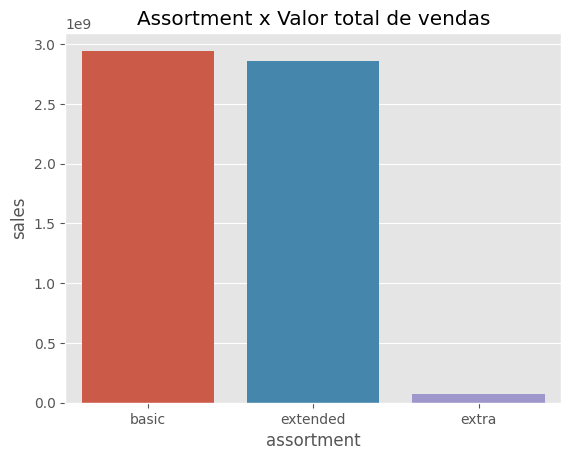

In [44]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(data=aux1, x='assortment', y='sales')
plt.title('Assortment x Valor total de vendas')
plt.show()

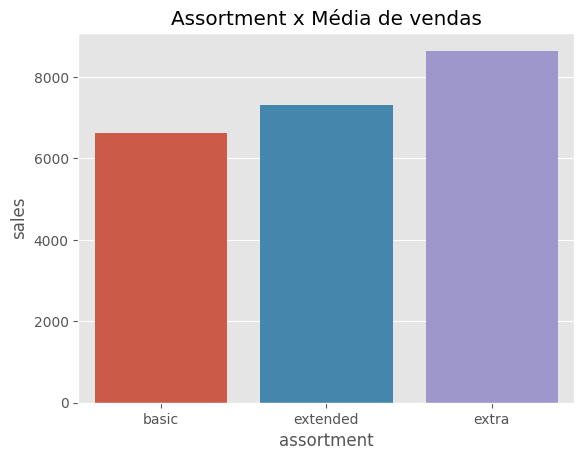

In [45]:
aux2 = df4[['assortment', 'sales']].groupby('assortment').mean().reset_index()
sns.barplot(data=aux2, x='assortment', y='sales')
plt.title('Assortment x Média de vendas')
plt.show()

**Teste ANOVA**

Premissas do teste ANOVA:
* As amostras são independentes.
* Cada amostra foi retirada de uma população distribuída normalmente.
* Os desvios padrões da população dos grupos é igual. Essa propriedade é conhecida como homocedasticidade

In [46]:
num_sample = 8000
basic = df4[df4['assortment'] == 'basic'].sample(num_sample)['sales']
extended = df4[df4['assortment'] == 'extended'].sample(num_sample)['sales']
extra = df4[df4['assortment'] == 'extra']['sales'].sample(num_sample)

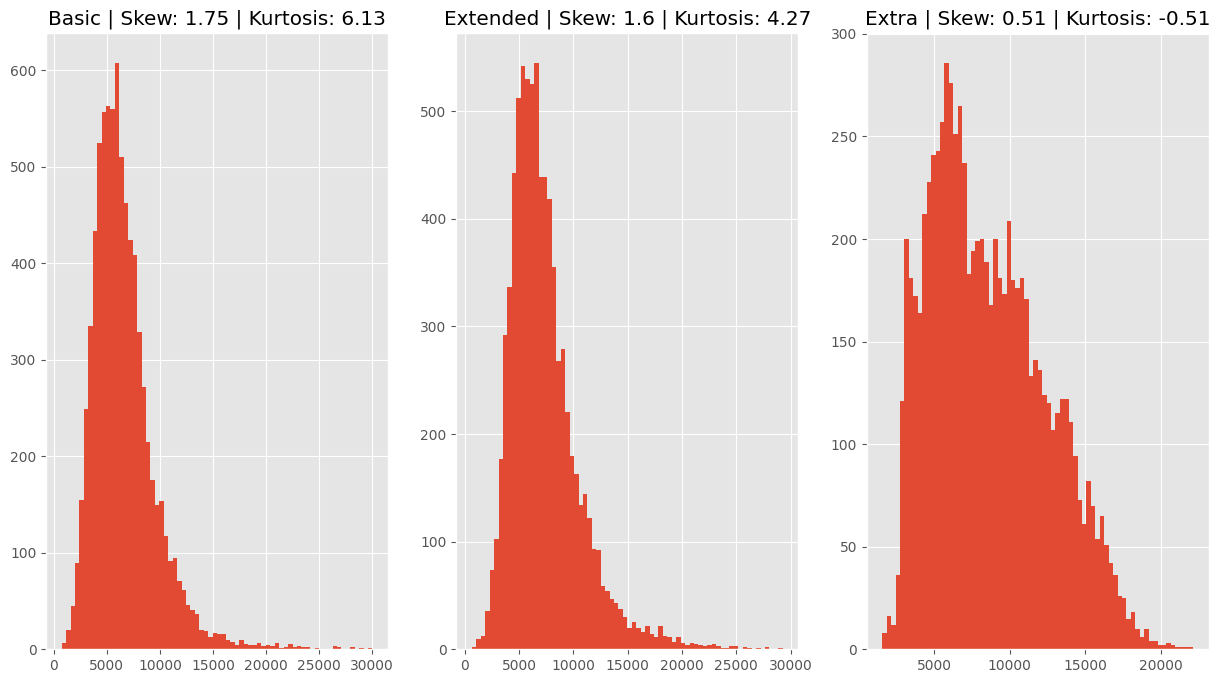

In [47]:
plt.figure(figsize=(15, 8))

plt.subplot(1, 3, 1)
basic.hist(bins=70)
plt.title(f"Basic | Skew: {basic.skew().round(2)} | Kurtosis: {basic.kurtosis().round(2)}")

plt.subplot(1, 3, 2)
extended.hist(bins=70)
plt.title(f"Extended | Skew: {extended.skew().round(2)} | Kurtosis: {extended.kurtosis().round(2)}")

plt.subplot(1, 3, 3)
extra.hist(bins=70)
plt.title(f"Extra | Skew: {extra.skew().round(2)} | Kurtosis: {extra.kurtosis().round(2)}")


plt.show()

In [48]:
std_basic = df4[df4['assortment'] == 'basic']['sales'].std()
std_extended = df4[df4['assortment'] == 'extended']['sales'].std()
std_extra = df4[df4['assortment'] == 'extra']['sales'].std()

print(f'Std basic: {std_basic} \nStd extended: {std_extended}\nStd extra: {std_extra}')

Std basic: 2972.0501740370214 
Std extended: 3183.849716949195
Std extra: 3803.1160308196213


In [49]:
f, p = f_oneway(np.log(basic), np.log(extended), np.log(extra))
print('p-valor: ', p)

p-valor:  3.858657952214879e-287


Um valor-p muito pequeno, significa que existe uma alta probabilidade de que os resultados observados não sejam devidos ao acaso, e sim a uma diferença real entre as médias de vendas das três categorias de variedade de produtos.

Isso significa que é possível pode rejeitar a hipótese nula (de que não há diferença significativa entre as médias de vendas das três categorias de variedade de produtos) e concluir que há uma diferença significativa entre as médias de vendas das três categorias de variedade de produtos.

Parece haver uma tendência de que as lojas com grande quantidade de produtos diferentes vendem mais do que as lojas com média e pequena quantidade de produtos diferentes. Entretanto, para ter certeza disso, seria necessário realizar comparações múltiplas entre as médias de vendas para cada categoria de variedade de produtos usando testes post-hoc, como o teste Tukey ou o teste de Scheffé, para confirmar quais combinações de médias são significativamente diferentes. 

**Vendas de cada categoria de assortment ao longo do tempo**

In [50]:
aux3 = df4[['year_week', 'assortment', 'sales']].groupby(["year_week", "assortment"]).sum().reset_index()

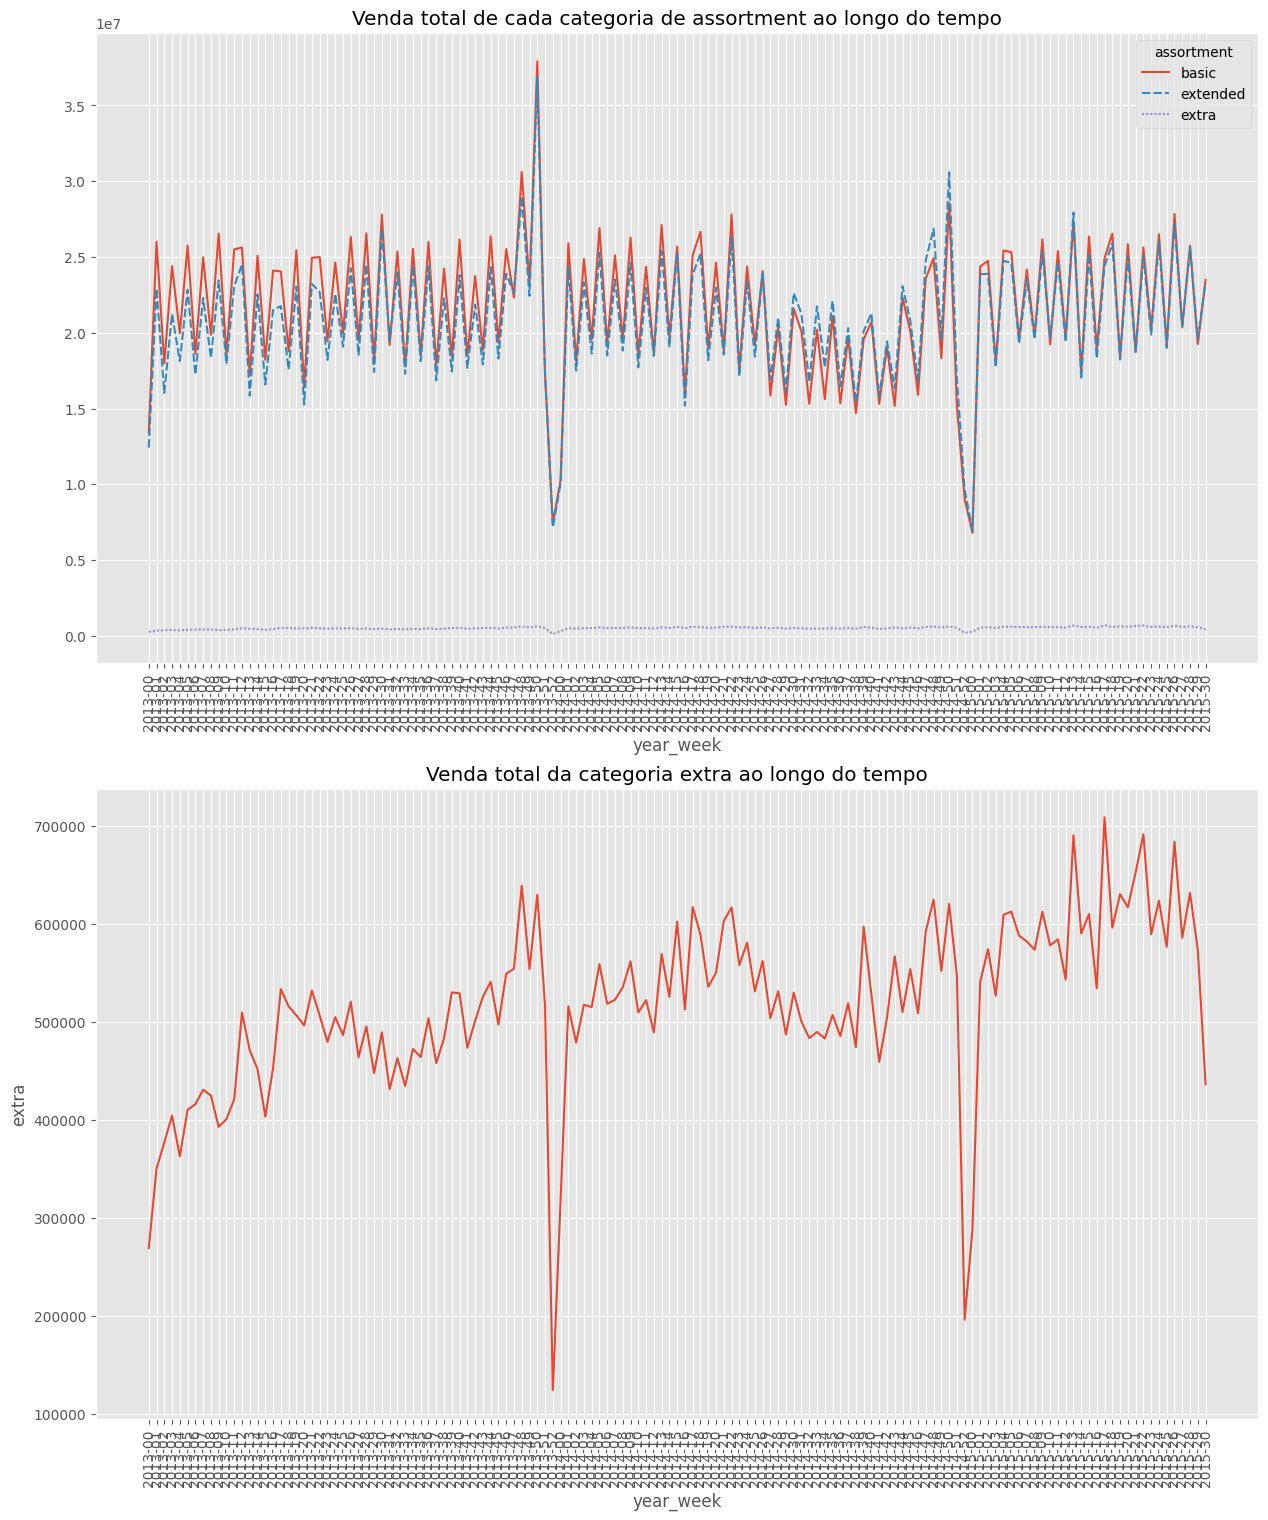

In [51]:
plt.figure(figsize=(15,18))

plt.subplot(2, 1, 1)
sns.lineplot(aux3.pivot(index='year_week', columns='assortment', values='sales'))
plt.xticks(rotation=90)
plt.title('Venda total de cada categoria de assortment ao longo do tempo')

plt.subplot(2, 1, 2)
sns.lineplot(aux3.pivot(index='year_week', columns='assortment', values='sales')['extra'])
plt.xticks(rotation=90)
plt.title('Venda total da categoria extra ao longo do tempo')

plt.show()

### H2. Lojas com competidores mais próximos deveriam vender menos.
**FALSO** Lojas com competidores mais próximos vendem mais.

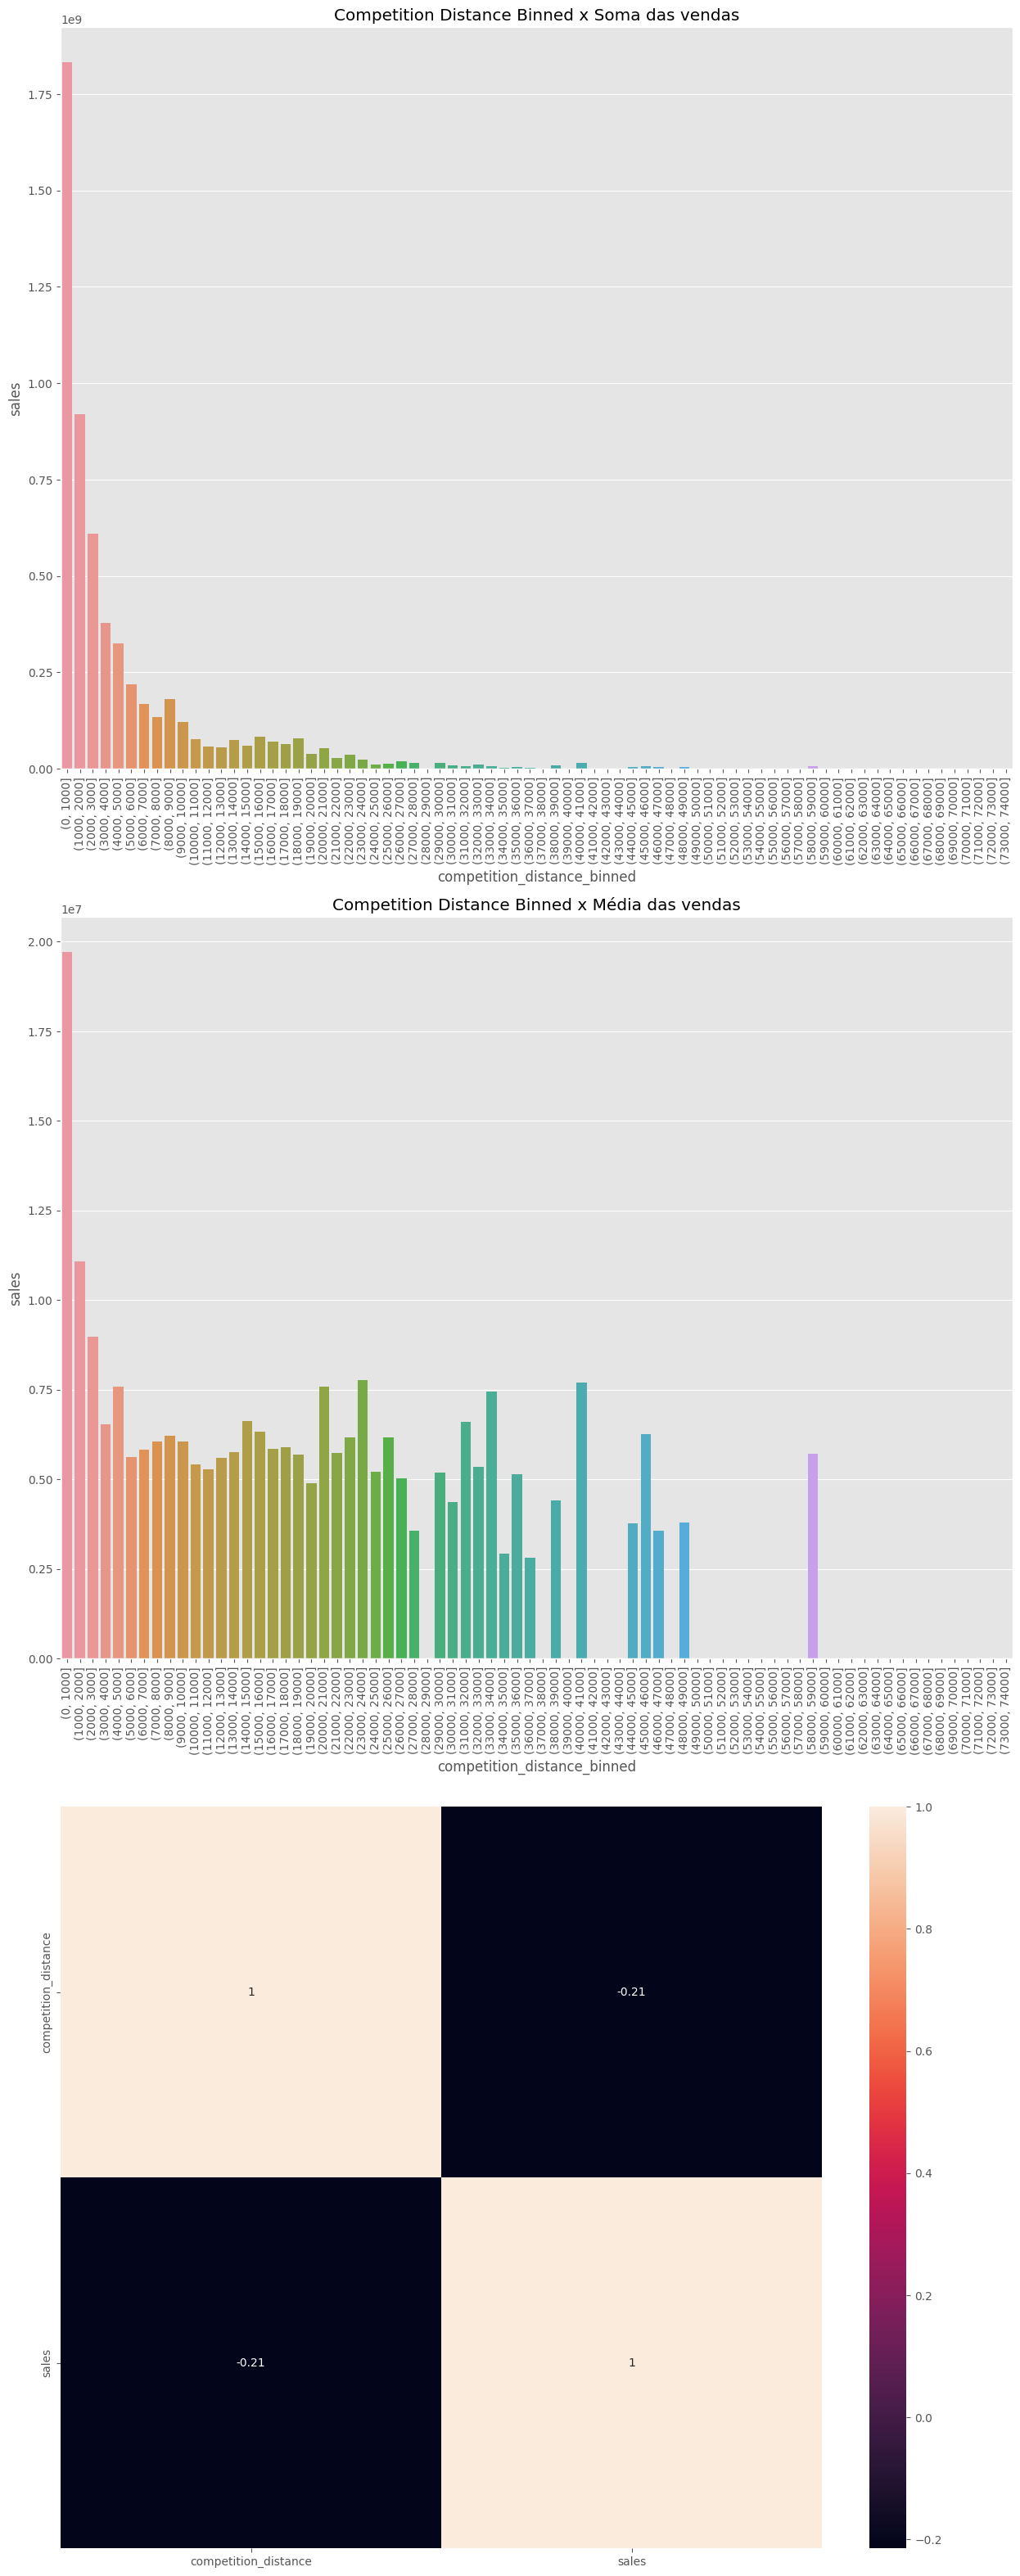

In [52]:
#agrupando por distância
aux1 = df4[['competition_distance', 'sales']].groupby("competition_distance").sum().reset_index()

#criando os bins
bins = list(np.arange(0, 75000, 1000))

#'binando' competition_distance
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)



#gráficos
plt.figure(figsize=(15, 40))

plt.subplot(3,1,1)
#agrupando vendas pelas categorias de distância (soma)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(data=aux2, x='competition_distance_binned', y='sales')
plt.title("Competition Distance Binned x Soma das vendas")
plt.xticks(rotation=90)

plt.subplot(3,1,2)
#agrupando vendas pelas categorias de distância (média)
aux3 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').mean().reset_index()
sns.barplot(data=aux3, x='competition_distance_binned', y='sales')
plt.title("Competition Distance Binned x Média das vendas")
plt.xticks(rotation=90)

plt.subplot(3,1,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

plt.show()

### H3. Lojas com competidores à mais tempo deveriam vendem mais.
**FALSO** Lojas com competidores mais próximos vendem mais.

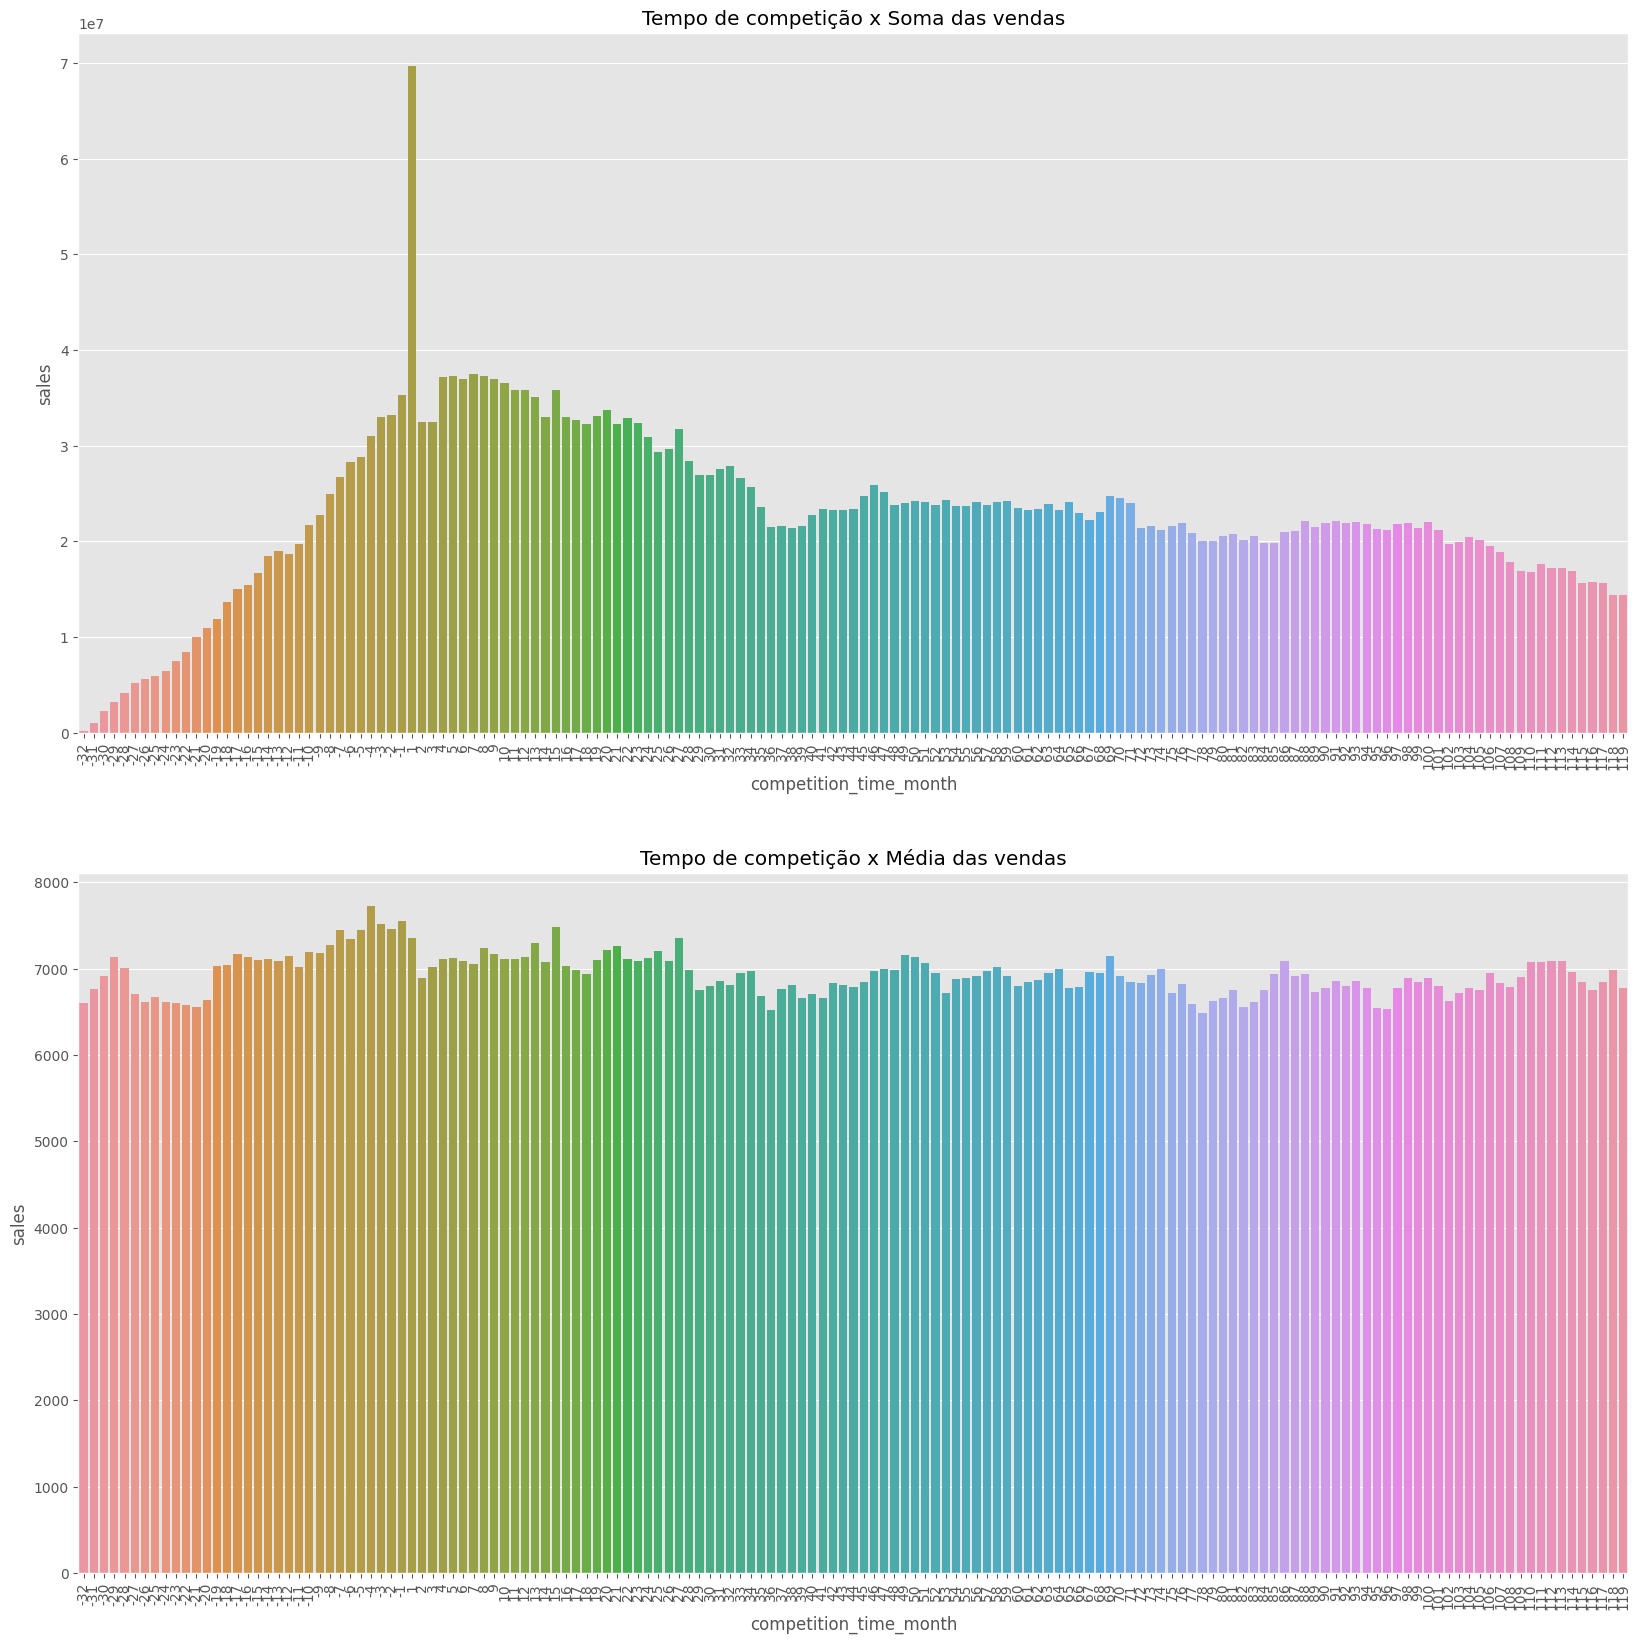

In [53]:
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux1 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]

aux2 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').mean().reset_index()
aux2 = aux2[(aux2['competition_time_month'] < 120) & (aux2['competition_time_month'] != 0)]

#gráficos
plt.figure(figsize=(20,20))

plt.subplot(2,1,1)
sns.barplot(data=aux1, x='competition_time_month', y='sales')
plt.title('Tempo de competição x Soma das vendas')
plt.xticks(rotation=90)

plt.subplot(2,1,2)
sns.barplot(data=aux2, x='competition_time_month', y='sales')
plt.title('Tempo de competição x Média das vendas')
plt.xticks(rotation=90)

plt.show()

### H4. Lojas com promoções ativas por mais tempo deveriam vender mais.

**FALSO** Lojas com promocoes ativas por mais tempo vendem menos, depois de um certo perÍodo
de promoção.

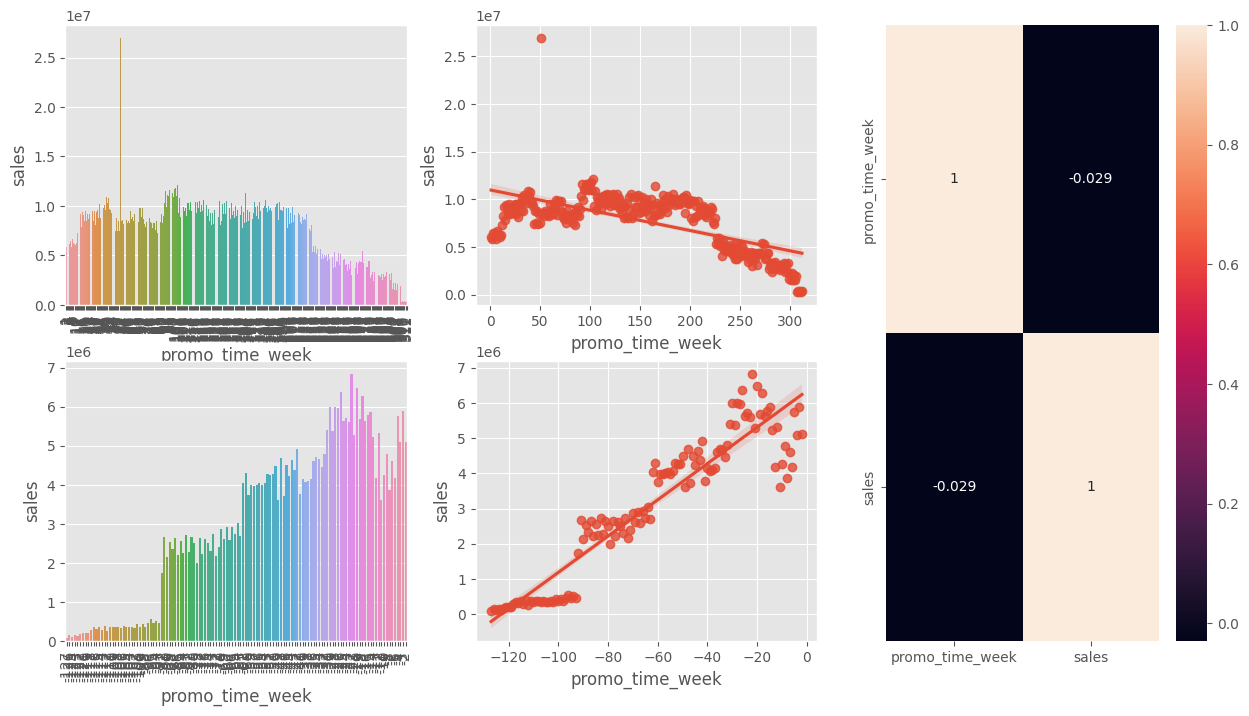

In [54]:
aux1 = df4[['promo_time_week', 'sales']].groupby( 'promo_time_week').sum().reset_index()

plt.figure(figsize=(15, 8))

grid = GridSpec( 2, 3 )

plt.subplot( grid[0,0] )
aux2 = aux1[aux1['promo_time_week'] > 0] # promo extendido
sns.barplot( x='promo_time_week', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( grid[0,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux2 );

plt.subplot( grid[1,0] )
aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular
sns.barplot( x='promo_time_week', y='sales', data=aux3 );
plt.xticks( rotation=90 );

plt.subplot( grid[1,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux3 );

plt.subplot( grid[:,2] )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### <s> H5. Lojas com mais dias de promoção deveriam vender mais. </s>
**PRÓXIMO CICLO DO CRISP-DS**

### H6. Lojas com mais promoções consecutivas deveriam vender mais


**FALSO** Lojas com mais promocoes consecutivas vendem menos

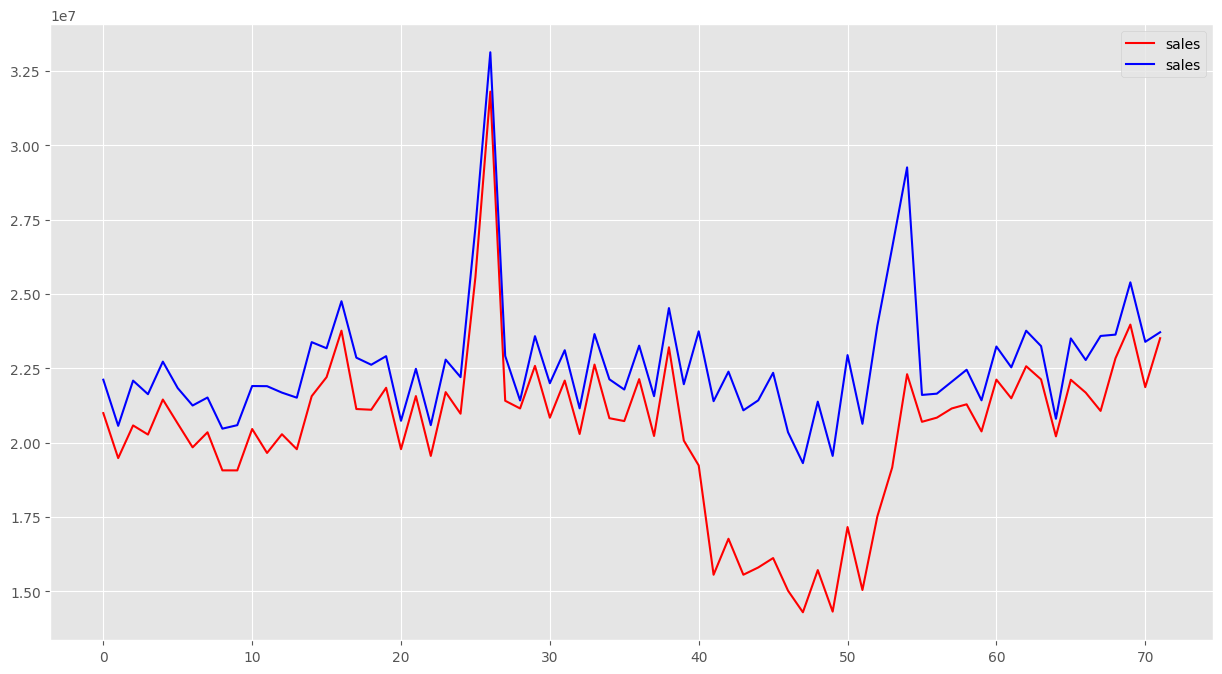

In [55]:
aux1 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 1 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
aux2 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 0 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()

plt.figure(figsize=(15,8))

ax1 = sns.lineplot(aux1, palette=['r'])
sns.lineplot(aux2, palette=['b'], ax=ax1)

plt.show()

### **H7.** Lojas abertas durante o feriado de Natal deveriam vender mais.
**FALSO** Lojas abertas durante o feriado do Natal vendem menos.


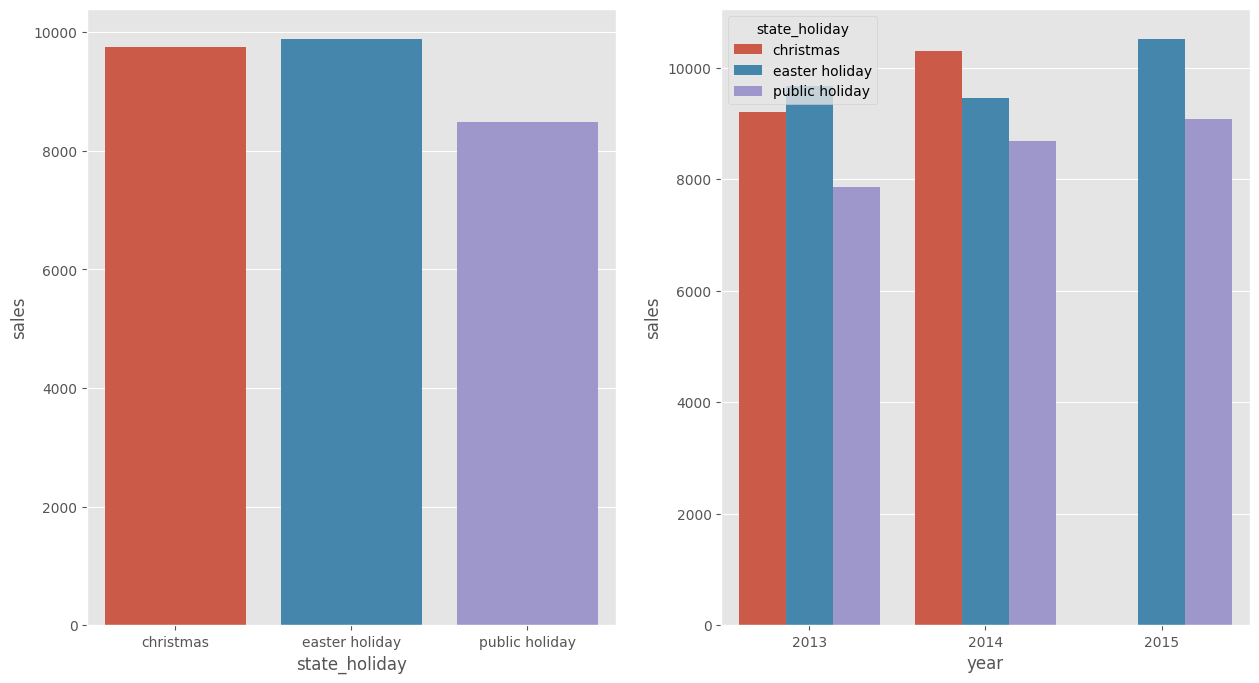

In [56]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.figure(figsize=(15,8))

plt.subplot( 1, 2, 1 )
aux1 = aux[['state_holiday', 'sales']].groupby( 'state_holiday' ).mean().reset_index()
sns.barplot( x='state_holiday', y='sales', data=aux1 );

plt.subplot( 1, 2, 2 )
aux2 = aux[['year', 'state_holiday', 'sales']].groupby( ['year', 'state_holiday'] ).mean().reset_index()
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2 );

### **H8.** Lojas deveriam vender mais ao longo dos anos.
**FALSO** Lojas vendem menos ao longo dos anos

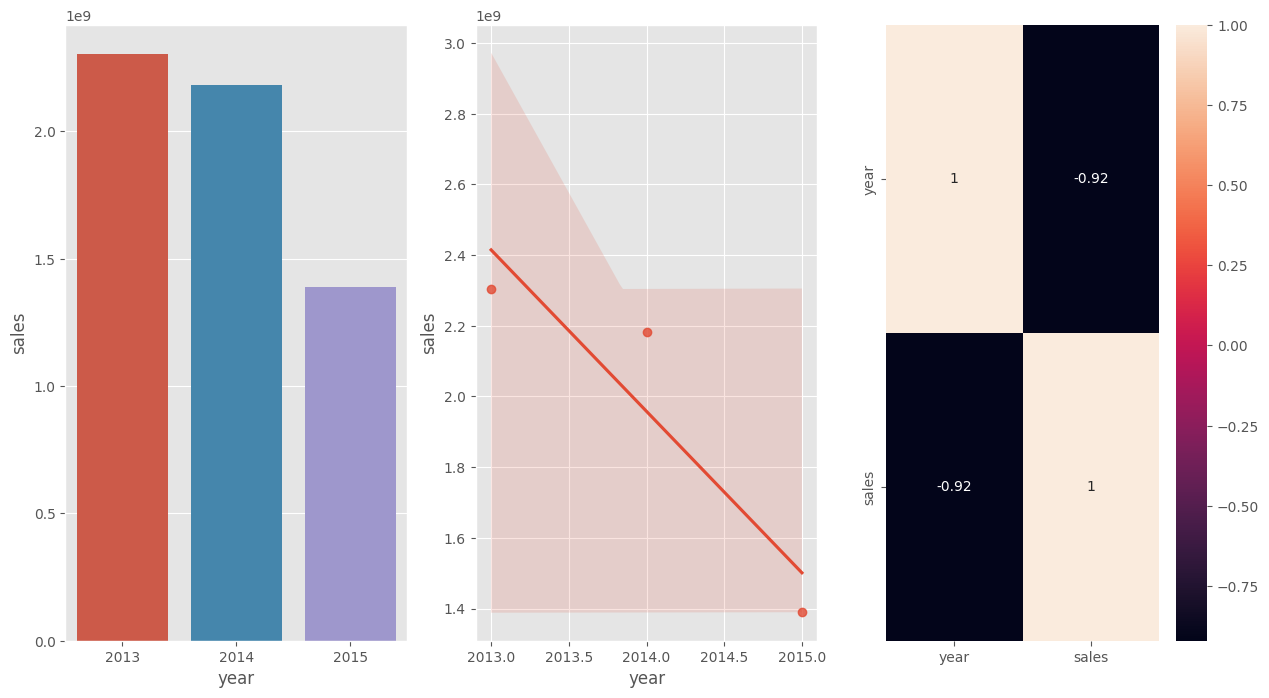

In [57]:
aux1 = df4[['year', 'sales']].groupby( 'year' ).sum().reset_index()

plt.figure(figsize=(15, 8))

plt.subplot( 1, 3, 1 )
sns.barplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### **H9**. Lojas deveriam vender mais no segundo semestre do ano.
**FALSO** Lojas vendem menos no segundo semestre do ano

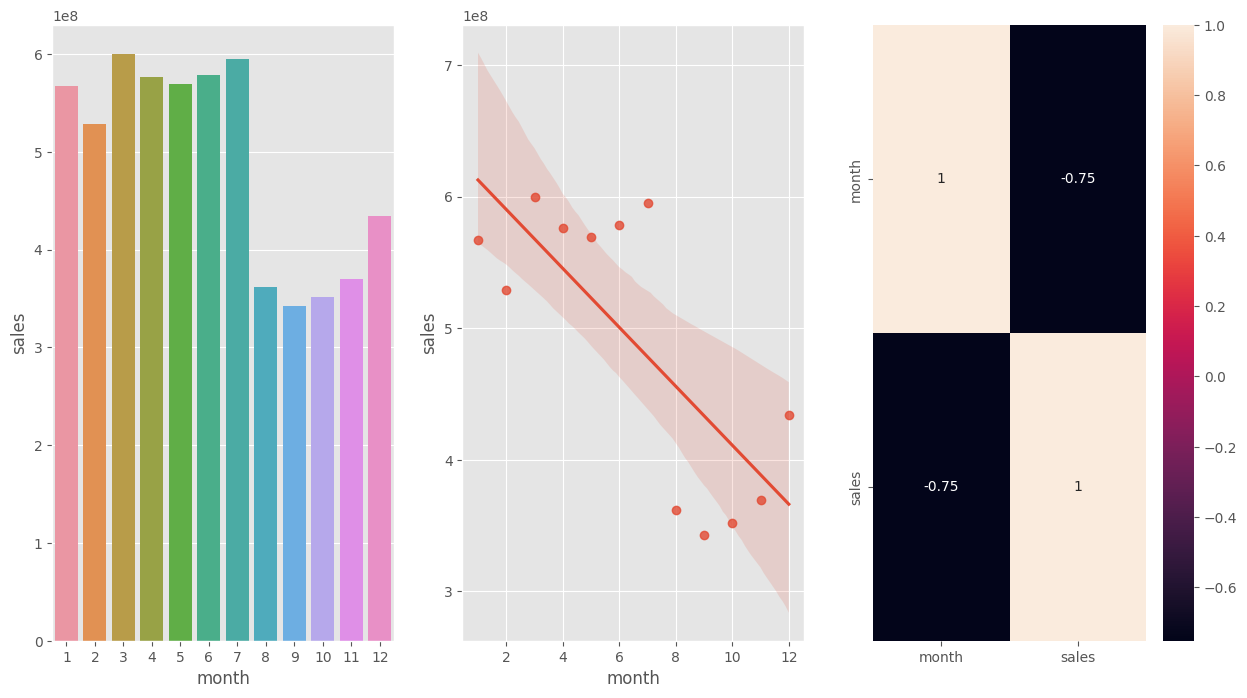

In [58]:
aux1 = df4[['month', 'sales']].groupby( 'month' ).sum().reset_index()

plt.figure(figsize=(15, 8))

plt.subplot( 1, 3, 1 )
sns.barplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### **H10**. Lojas deveriam vender mais depois do dia 10 (dia do pagamento) de cada mês.
**VERDADEIRA** Lojas vendem mais depois do dia 10 de cada mes.

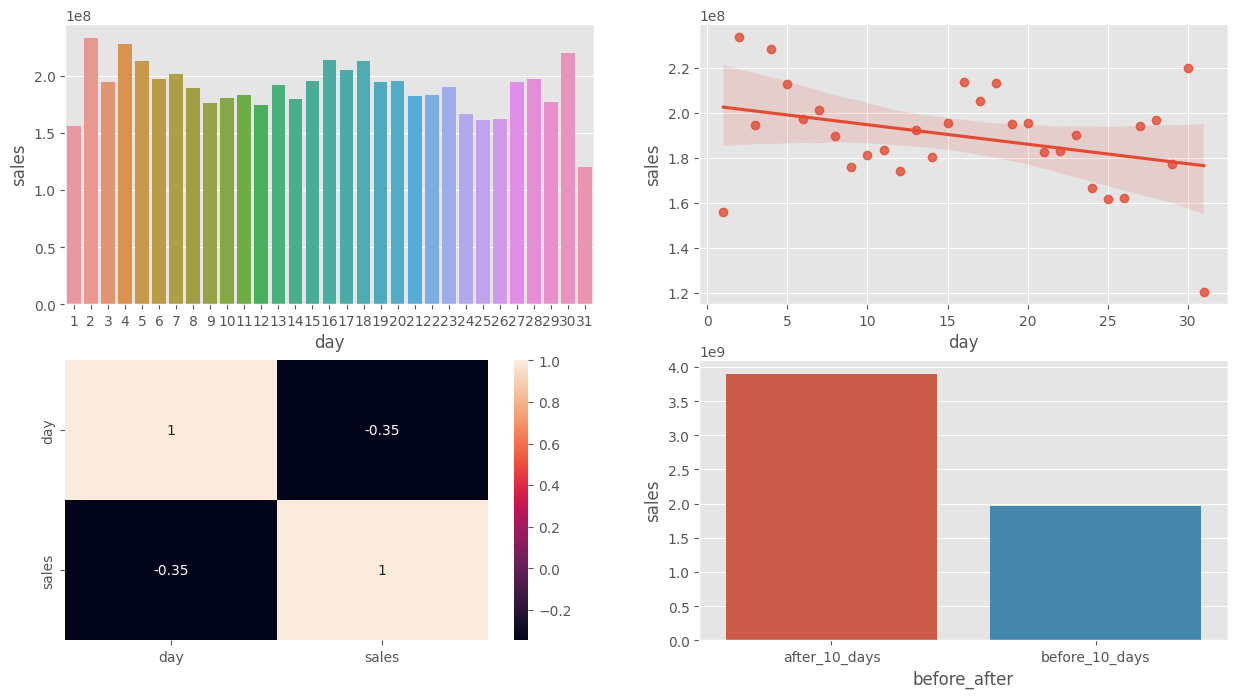

In [59]:
aux1 = df4[['day', 'sales']].groupby( 'day' ).sum().reset_index()

plt.figure(figsize=(15, 8))

plt.subplot( 2, 2, 1 )
sns.barplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 2 )
sns.regplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days' )
aux2 =aux1[['before_after', 'sales']].groupby( 'before_after' ).sum().reset_index()
plt.subplot( 2, 2, 4 )
sns.barplot( x='before_after', y='sales', data=aux2 );

### **H11**. Lojas deveriam vender menos aos finais de semana.
**VERDADEIRA** Lojas vendem menos nos final de semana

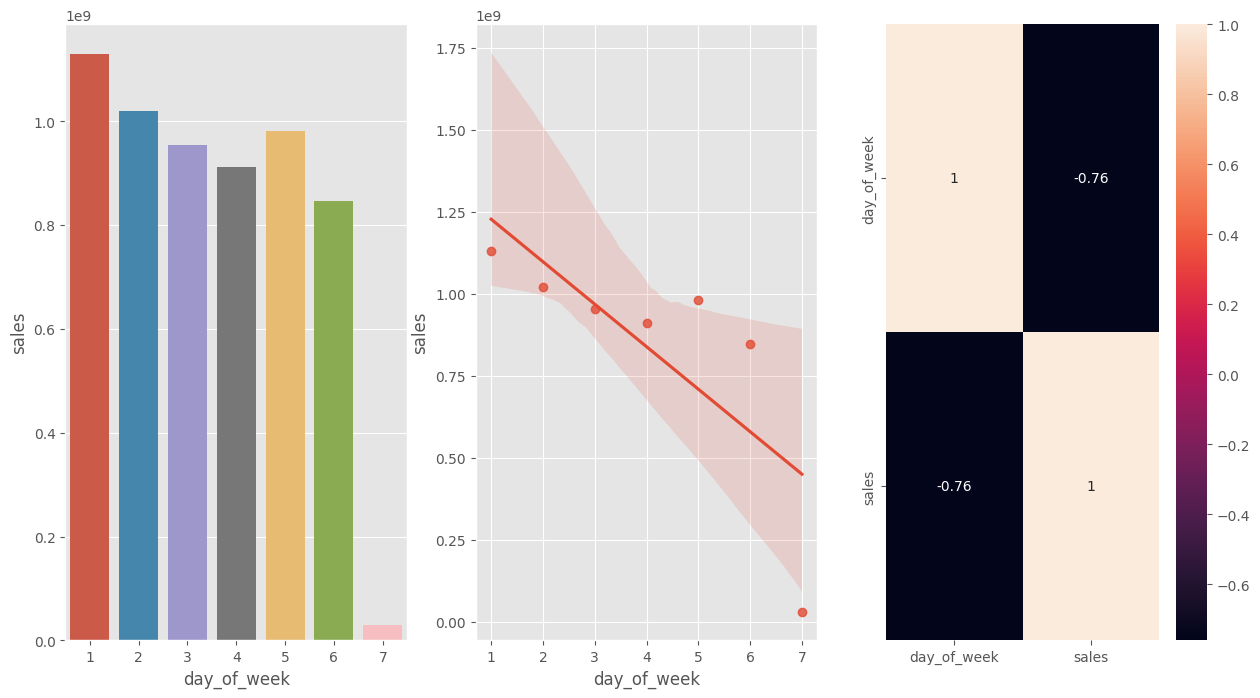

In [60]:
aux1 = df4[['day_of_week', 'sales']].groupby( 'day_of_week' ).sum().reset_index()
    
plt.figure(figsize=(15, 8))    

plt.subplot( 1, 3, 1 )
sns.barplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### **H12**. Lojas deveriam vender menos durante os feriados escolares
**VERDADEIRA** Lojas vendem menos durante os feriados escolares, except os meses de Julho e Agosto

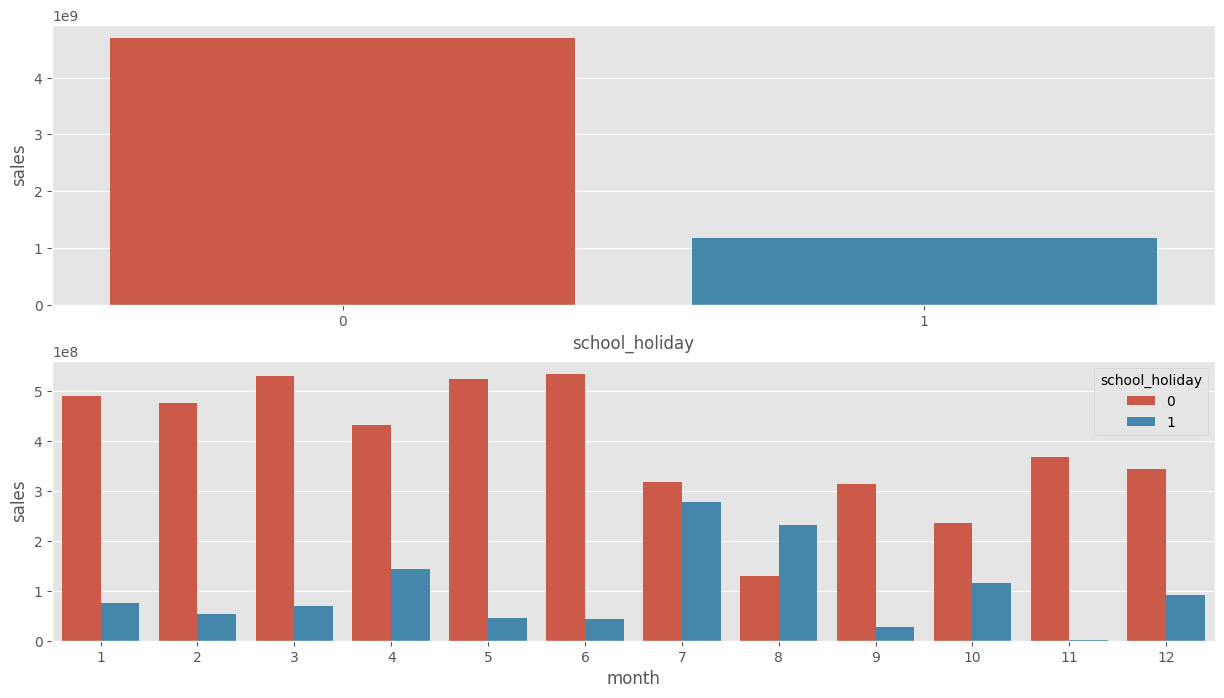

In [61]:
aux1 = df4[['school_holiday', 'sales']].groupby( 'school_holiday' ).sum().reset_index()

plt.figure(figsize=(15, 8))

plt.subplot( 2, 1, 1 )
sns.barplot( x='school_holiday', y='sales', data=aux1 );

aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month','school_holiday'] ).sum().reset_index()
plt.subplot( 2, 1, 2 )
sns.barplot( x='month', y='sales', hue='school_holiday', data=aux2 );

### Conclusão dos resultados

In [62]:
 tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
['H1', 'Falsa', 'Baixa'],
['H2', 'Falsa', 'Media'],
['H3', 'Falsa', 'Media'],
['H4', 'Falsa', 'Baixa'],
['H5', '-', '-'],
['H6', 'Falsa', 'Baixa'],
['H7', 'Falsa', 'Media'],
['H8', 'Falsa', 'Alta'],
['H9', 'Falsa', 'Alta'],
['H10', 'Verdadeira', 'Alta'],
['H11', 'Verdadeira', 'Alta'],
['H12', 'Verdadeira', 'Baixa'],
]
print(tabulate(tab, headers='firstrow'))

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H6           Falsa        Baixa
H7           Falsa        Media
H8           Falsa        Alta
H9           Falsa        Alta
H10          Verdadeira   Alta
H11          Verdadeira   Alta
H12          Verdadeira   Baixa


## 4.3 Análise Multivariada

### Qual é a motivação por trás dessa tarefa?

Os algoritmos de machine learning eles seguem algumas premissas. Uma delas é a teoria de Occam's Razzor, ou, A navalha de Occam. Ela diz que se tiver vários modelos para escolher, deve-se escolher o de menor complexidade, pois ele generaliza o aprendizado melhor. Existem várias maneiras de deixar o modelo mais complexo, uma delas é a dimensionalidade. Para diminuir a dimensionalidade pode diminuir colunas do dataset. 

Como tirar colunuas do dataset? Um dos critérios é a quantidade de informação que elas carregam. Se tem duas colunas que carregam a mesma quantidade de informação, pode tirar uma delas que não terá perda de informação. 

Como encontrar variáveis que carregam a mesma quantidade de informação?
Uma das maneiras é olhar para a correlação. Existem outras formas, da Alg Lin e Geom Analítica, mas a correlação é uma delas também.

A análise multivariada ajuda a olhar quais variáveis são correlacionadas e portanto podem ser retiradas para reduzir a dimensionalidade do dataset e diminuir a complexidade do modelo.

### 4.3.1 Numerical Attributes

O coeficiente de Pearson, conhecido também como Pearson's r, Correlação Bivariada ou apenas Coeficiente de Correlação, é uma medida que indica se o quão forte é a correlação LINEAR entre duas variáveis quantitativas. Obs: duas variáveis podem possuir correlação apesar de o coeficiente de Pearson apontar que não, isso porque esse coeficiente avalia apenas correlações lineares (X cresce, Y também cresce; X decresce, Y também decresce).

A tabela abaixo mostra algumas regras para avaliar a correlação indicada pelo coeficiente:


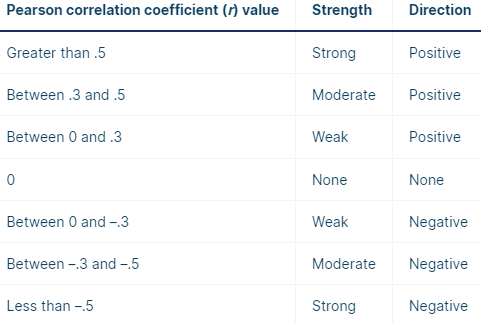


O coeficiente de correlação de Pearson é uma boa escolha quando todas as seguintes condições são verdadeiras:

* Ambas as variáveis são quantitativas: será necessário usar um método diferente se uma das variáveis for qualitativa.


* As variáveis são normalmente distribuídas: é possível criar um histograma de cada variável para verificar se as distribuições são aproximadamente normais. Não é um problema se as variáveis forem um pouco não-normais.


* Os dados não têm outliers: outliers são observações que não seguem os mesmos padrões do resto dos dados. Um gráfico de dispersão é uma maneira de verificar por outliers - procure por pontos que estão longe dos outros.


* A relação é linear: "linear" significa que a relação entre as duas variáveis pode ser descrita razoavelmente bem por uma linha reta. Você pode usar um gráfico de dispersão para verificar se a relação entre as duas variáveis é linear.


A fórmula para calcular o coef de Pearson é a seguinte:


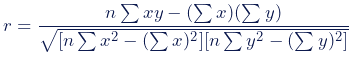



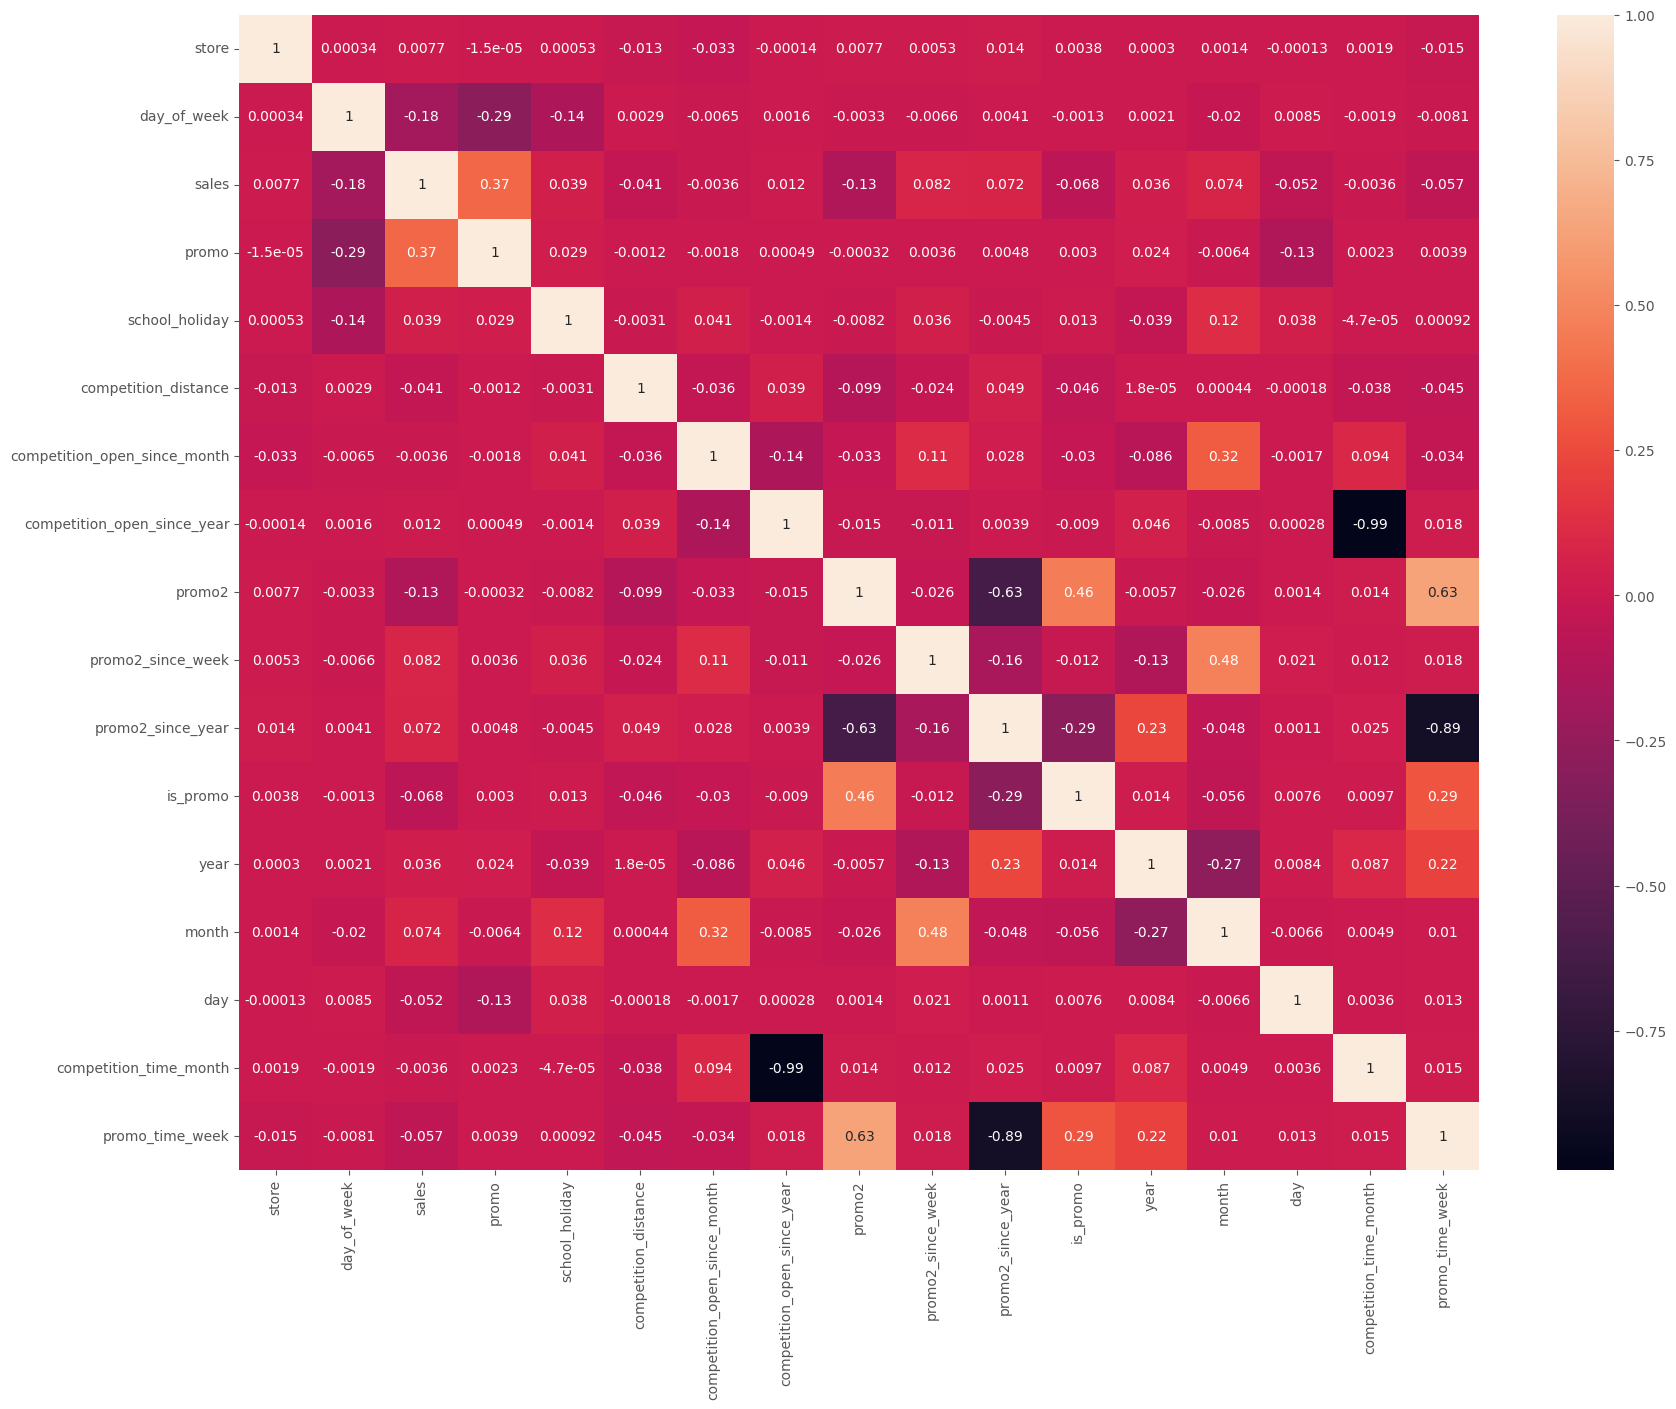

In [63]:
correlation = num_attributes.corr(method='pearson')
plt.figure(figsize=(20, 15))
sns.heatmap(correlation, annot=True)
plt.show()

### 4.3.2 Categorical Attributes

O teste Chi2 (Qui-Quadrado) é um teste de hipótese que é utilizado quando queremos determinar se existe relação entre duas variáveis categóricas ou não. Por exemplo: existe reção entre o tipo de loja e o assortment das lojas?

Condições para ser válido:
* A amostra deve ser relativamente grande (pelo menos 5 observações em cada célula)
* Independência: os dados devem ser coletados de forma independente. Isso significa que a ocorrência de um evento em uma categoria não deve afetar a ocorrência de eventos em outras categorias.

É um teste não paramétrico. Os testes não-paramétricos são usados para dados que não seguem as suposições dos testes paramétricos, especialmente a suposição de uma distribuição normal.

Para calcular o Chi2, deve-se seguir o seguintes passos:

1. Determinar as hipóteses nula e alternativa. A hipótese nula é geralmente que não há diferença significativa entre as frequências observadas e esperadas, enquanto a hipótese alternativa é que há uma diferença significativa.


2. Organizar os dados em uma tabela de contingência. Isso inclui colunas para cada categoria da variável independente e linhas para cada categoria da variável dependente.


3. Calcular as frequências esperadas para cada célula da tabela de contingência. Aqui estamos considerando uma tabela onde as variáveis são independentes. Segue o passo a passo para isso:

    1. Calcular a soma total das frequências observadas para cada linha da tabela de contingência. Isso é chamado de frequência marginal da linha.

    2. Calcular a soma total das frequências observadas para cada coluna da tabela de contingência. Isso é chamado de frequência marginal da coluna.

    3. Calcular a soma total das frequências observadas para toda a tabela de contingência. Isso é chamado de frequência total.

    4. Para cada célula da tabela de contingência, calcular a frequência esperada usando a seguinte fórmula: (frequência marginal da linha * frequência marginal da coluna) / frequência total.


4. Calcular o valor chi-quadrado para cada célula da tabela de contingência. Isso pode ser feito usando a fórmula: (frequência observada - frequência esperada) ^ 2 / frequência esperada.


5. Calcular o valor chi-quadrado total somando os valores chi-quadrado calculados para cada célula.


6. Consultar a tabela de chi-quadrado para encontrar o valor crítico correspondente ao nível de significância escolhido e o número de graus de liberdade (número de categorias menos 1).


7. Comparar o valor chi-quadrado total calculado com o valor crítico encontrado na tabela. Se o valor chi-quadrado total for maior do que o valor crítico, rejeita-se a hipótese nula e conclui-se que há uma diferença significativa entre as frequências observadas e esperadas, ou seja, as variáveis spossuem relação entre si. Caso o valor chi-quadrado for menor do que o valor crítico, não rejeitamos a hipótese nula, de que não há diferença significativa entre as frequências observadas e esperadas.

<b>Chi-quadrado X Cramer's V e Coeficiente de Contingência (Phi)</b>

O valor do chi-quadrado pode ser difícil de interpretar e comparar entre diferentes tamanhos de amostra e números de categorias. O chi-quadrado é apenas uma medida de diferença entre as frequências observadas e esperadas.

Para tornar a interpretação e a compração de diferentes valores de chi-quadrado mais fáceis, duas medidas de associação entre as variáveis categóricas foram desenvolvidas. Essas medidas são normalizadas, ou seja, transformados em uma escala comum (de -1 a 1 para o phi e de 0 a 1 para o Cramer's V) para facilitar a comparação entre diferentes tamanhos de amostra e números de categorias.

<b> Coeficiente de Contingência </b>

O coeficiente de contingência é uma medida de associação entre duas variáveis categóricas, geralmente usado para tabelas de contingência de dois níveis (nível -> quantidade de categorias que uma variável categórica possui). Ele é calculado usando o valor chi-quadrado e é dado pela seguinte fórmula:

phi = sqrt(χ^2 / N)

onde:
χ^2 é o valor calculado do chi-quadrado
N é o tamanho da amostra

O valor de phi varia de -1 a 1, onde -1 indica uma associação perfeita negativa, 1 indica uma associação perfeita positiva e 0 indica ausência de associação entre as variáveis.

<b>Cramer's V</b>

Cramer's V é uma medida de associação entre duas variáveis categóricas. Ele é usado para medir a força e a direção da relação entre as variáveis. É uma extensão do coeficiente de contingência para tabelas de contingência de mais de dois níveis.

Cramer's V é baseado no teste chi-quadrado e é calculado usando o valor chi-quadrado e o número de graus de liberdade. Ele é dado pela seguinte fórmula:

V = sqrt(χ^2 / (N * (min(k, r) - 1))

onde:
χ^2 é o valor calculado do chi-quadrado
N é o tamanho da amostra
k é o número de categorias na variável independente
r é o número de categorias na variável dependente

O valor de Cramer's V varia de 0 a 1, onde 0 indica ausência de associação e 1 indica uma associação perfeita. Valores próximos a 1 indicam uma forte associação entre as variáveis, enquanto valores próximos a 0 indicam uma fraca associação. Valores positivos indicam uma associação positiva entre as variáveis, enquanto valores negativos indicam uma associação negativa.

***É importante notar que o Cramer's V é um coeficiente de associação e não um teste estatístico. Ele não fornece informações sobre a significância estatística da relação entre as variáveis, para isso é preciso utilizar o teste qui-quadrado.***

<b>Extra</b>

<b> Teste de qualidade de ajuste qui-quadrado (godness of fit) </b>

Você pode usar um teste de ajuste qui-quadrado quando tiver uma variável categórica. Ele permite que você teste se a distribuição de frequência da variável categórica é significativamente diferente de suas expectativas. Muitas vezes, mas nem sempre, a expectativa é que as categorias tenham proporções iguais.

Expectativa de proporções iguais
* Hipótese nula ( H 0 ): As espécies de aves visitam o comedouro emproporções iguais .
* Hipótese alternativa ( H A ): As espécies de aves visitam o comedouro em diferentes proporções.

In [64]:
cat_attributes = cat_attributes.drop(["week_of_year", "year_week"], axis=1)

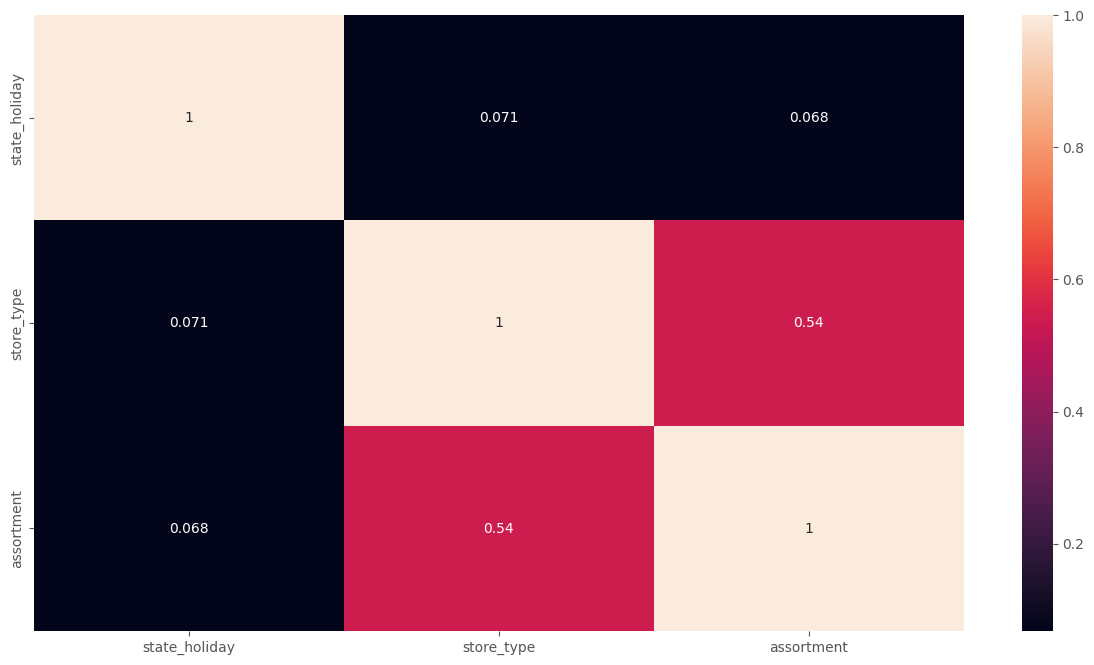

In [65]:
categorical_corr = get_categorical_corr(cat_attributes)

df_cat_corr = pd.DataFrame(categorical_corr)
df_cat_corr = df_cat_corr.set_index(df_cat_corr.columns)

plt.figure(figsize=(15, 8))
sns.heatmap(df_cat_corr, annot=True)
plt.show()

# 5.0 Preparação dos dados

In [276]:
df5 = df4.copy()

## Qual é a motivação por trás dessa tarefa?

O aprendizado da maioria dos algoritmos de Machine Learning é facilitado com dados numéricos, na mesma escala.

Tarefas realizadas nessa etapa:


1. Normalização
    * reescala o centro para 0 (média = 0) com desvio-padrão igual a 1.
    * funciona bem para variáveis que tem distribuição normal.
    
    
2. Rescaling
    * reescala para o intervalo entre 0 e 1. 
    * utilizado em variáveis que não seguem uma distribuição gaussiana.
    
    
3. Transformação
    * conversão de features categóricas para features numéricas (encoding).
    * transformação da natureza.

## 5.1 Separação dos dados em treino e teste

In [277]:
min_date = df5.date.min()
max_date = df5.date.max()
split_date = max_date - datetime.timedelta(days=6*7)

X_train = df5[df5['date'] < split_date]
y_train = X_train['sales']

X_test = df5[df5['date'] >= split_date]
y_test = X_test['sales']

X_train = X_train.drop('sales', axis=1)
X_test = X_test.drop('sales', axis=1)

In [278]:
print(f"Training Min Date: {X_train['date'].min()}")
print(f"Training Max Date: {X_train['date'].max()}")

print(f"\nTraining Min Date: {X_test['date'].min()}")
print(f"Training Max Date: {X_test['date'].max()}")

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Training Min Date: 2015-06-19 00:00:00
Training Max Date: 2015-07-31 00:00:00


## 5.2 Normalização

Analisando as distribuições das variáveis numéricas, nenhuma delas possui uma distribuição normal. Portanto, a normalização não será executada em nenhuma das variáveis.

## 5.3 Rescaling

<b> MinMaxScaler </b>

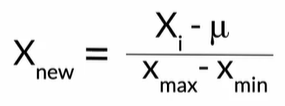

* Uma das vantagens desse Scaler é que ele mantém as distribuições no mesmo shape.
* Uma das desvantagens é que é muito sensível a outliers (ocorre divisão pelo Xmaximo da coluna - Xminimo, se Xmaximo é muito grande, ao subtrair do Xminimo, continuará um número muito grande, e um número dividido por um número muito grande dá um número muito pequeno)


<b> Robust Scaler </b>

Estratégia para lidar com essa sensibilidade a outliers presente no MinMaxScaler.

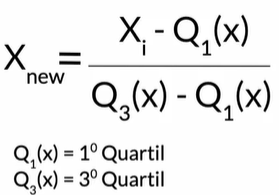

<br>
<br>



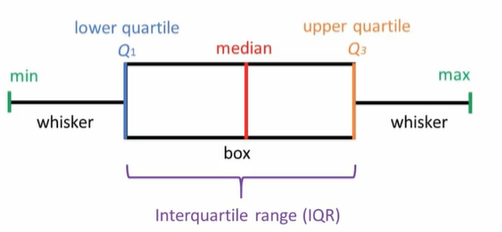

* Vantagem: lida com outliers
* Desvantagem: pode modificar a distribuição da variável

### Aplicando o rescaling

Variáveis ciclicas serão tratadas na seção "Transformações". (Mês (só vai do 1 ao 12 e qnd chega no 12 volta), dia)

<b> Verificando se as variáveis possuem outliers </b>

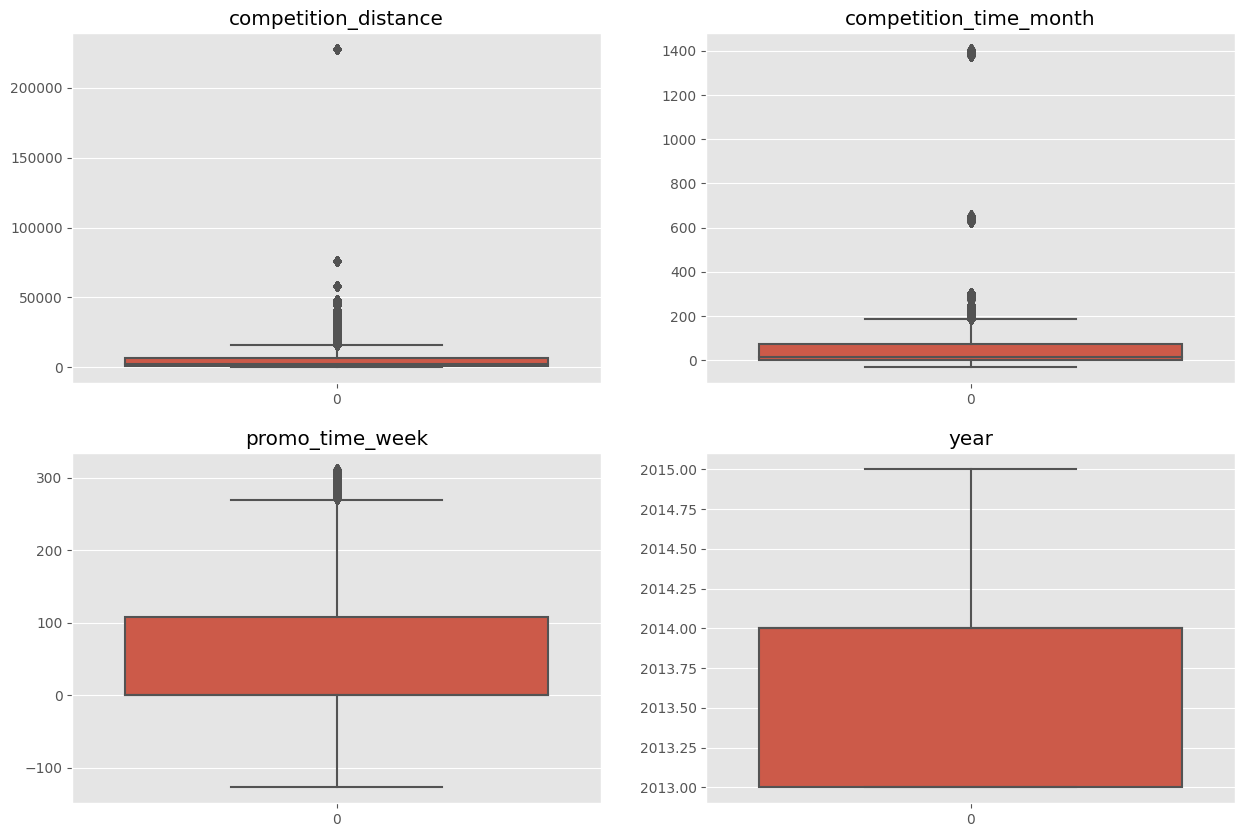

In [279]:
plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
sns.boxplot(df5['competition_distance'])
plt.title('competition_distance')

plt.subplot(2,2,2)
sns.boxplot(df5['competition_time_month'])
plt.title('competition_time_month')

plt.subplot(2,2,3)
sns.boxplot(df5['promo_time_week'])
plt.title('promo_time_week')

plt.subplot(2,2,4)
sns.boxplot(df5['year'])
plt.title('year')

plt.show()

In [280]:
rs = RobustScaler()
mms = MinMaxScaler()

#competition_distance
X_train['competition_distance'] = rs.fit_transform(X_train[['competition_distance']].values)
X_test['competition_distance'] = rs.transform(X_test[['competition_distance']].values)

#competition_time_month
X_train['competition_time_month'] = rs.fit_transform(X_train[['competition_time_month']].values)
X_test['competition_time_month'] = rs.transform(X_test[['competition_time_month']].values)

#promo_time_week - não possui outliers tão significantes, então irei arriscar utilizar o minmax
X_train['promo_time_week'] = mms.fit_transform(X_train[['promo_time_week']].values)
X_test['promo_time_week'] = mms.transform(X_test[['promo_time_week']].values)

#year
X_train['year'] = mms.fit_transform(X_train[['year']].values)
X_test['year'] = mms.transform(X_test[['year']].values)

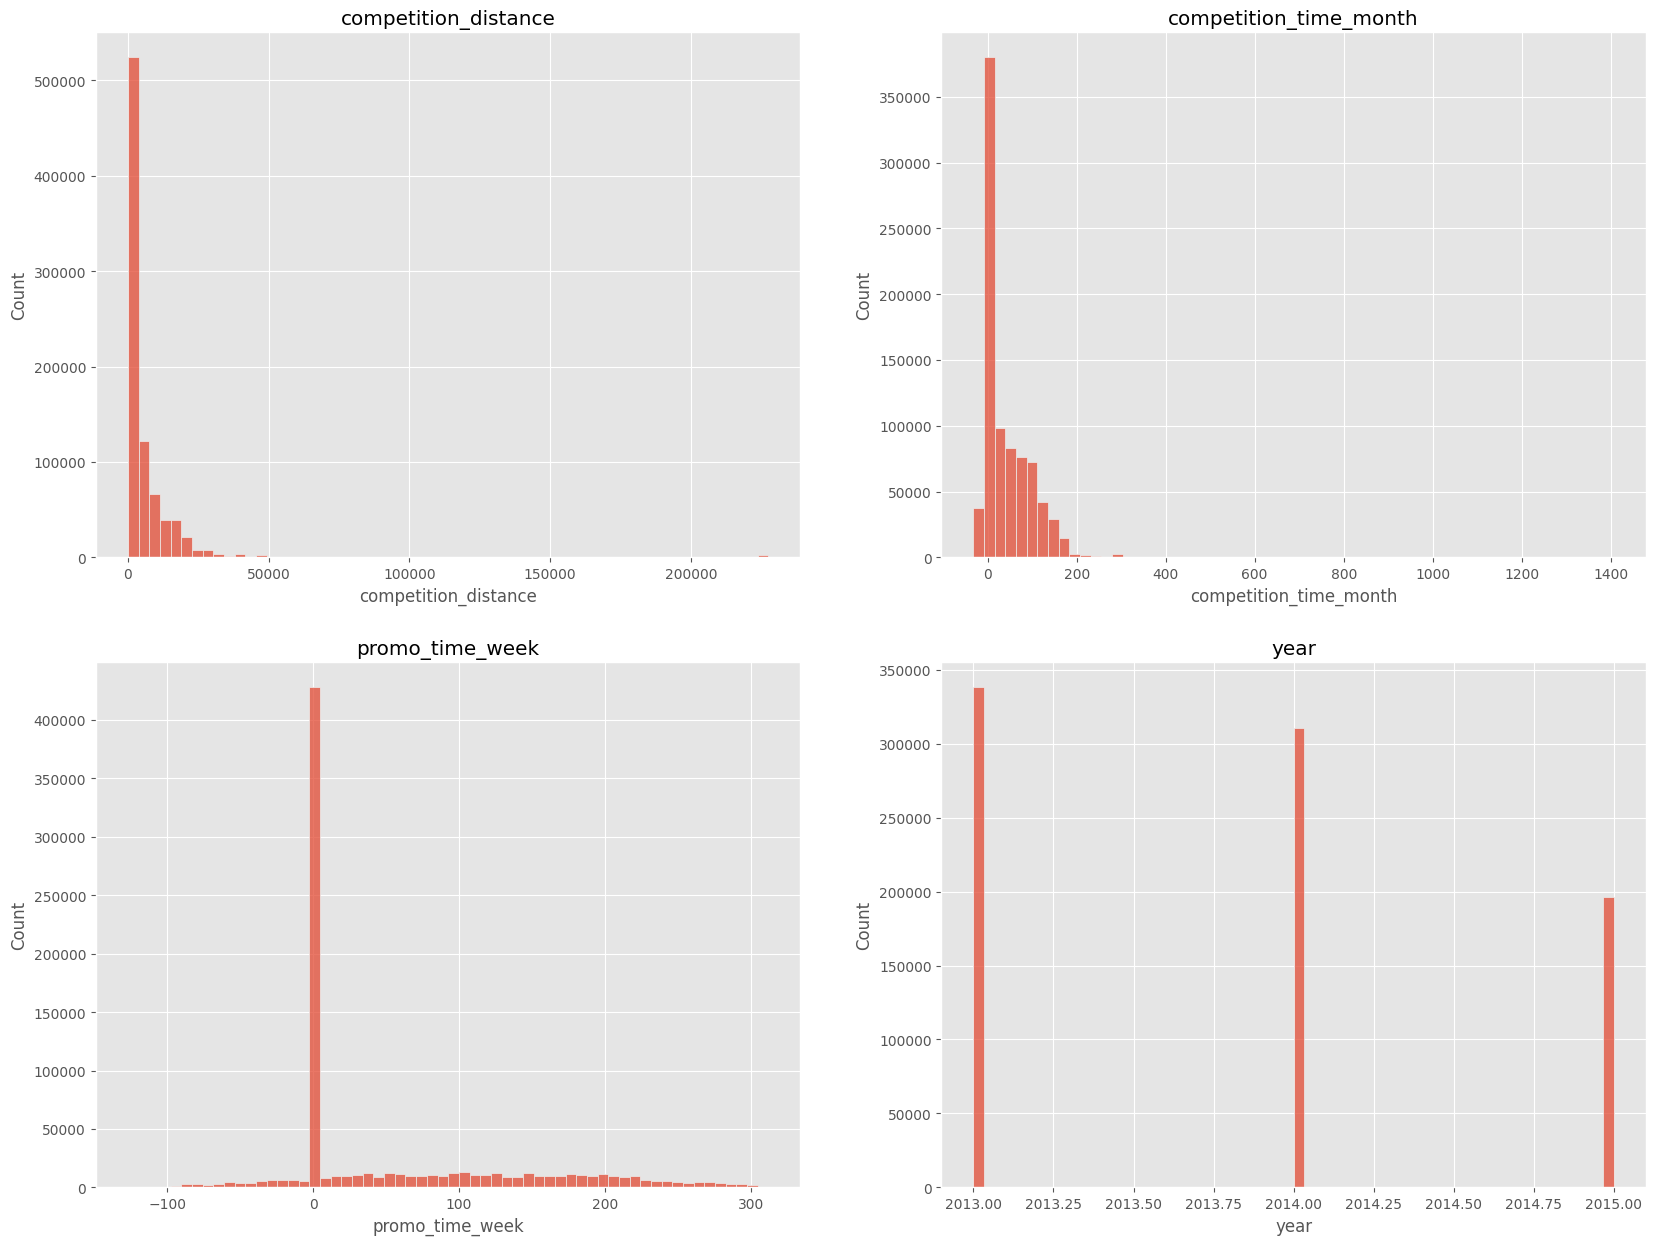

In [281]:
plt.figure(figsize=(20,15))

plt.subplot(2,2,1)
sns.histplot(df5['competition_distance'], bins=60)
plt.title('competition_distance')

plt.subplot(2,2,2)
sns.histplot(df5['competition_time_month'], bins=60)
plt.title('competition_time_month')

plt.subplot(2,2,3)
sns.histplot(df5['promo_time_week'], bins=60)
plt.title('promo_time_week')

plt.subplot(2,2,4)
sns.histplot(df5['year'], bins=60)
plt.title('year')

plt.show()

## 5.4 Transformações

### 5.4.1 Encoding

Existem vários tipos de encoding:

1. One Hot Encoding
    * Vantagem: simples de aplicar
    * Desvantagem: cria muitas colunas, aumentando a dimensionalidade, o que pode prejudicar o modelo (overfitando)
    * Funciona bem em variáveis que são estados de coisas (feriado -> a gente vive em um estado regular e no feriado estamos em outro estado)
    
    
2. Label Encoding
    * Funcionamento:
    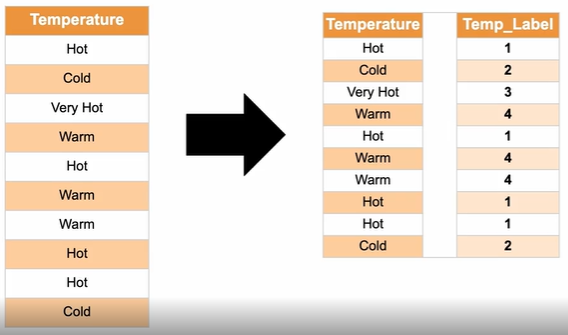
    
    * Funciona bem em variáveis que são apenas nomes (nomes de lojas..)
    
    
3. Ordinal Encoding
    * Funciona como o Label Encoding, mas ele dá os números de acordo com uma ordem
    * Tudo que tiver a ideia de maior ou menor dá pra utilizar o ordinal encoding
    
    
4. Target Encoding
    * Funcionamento:
    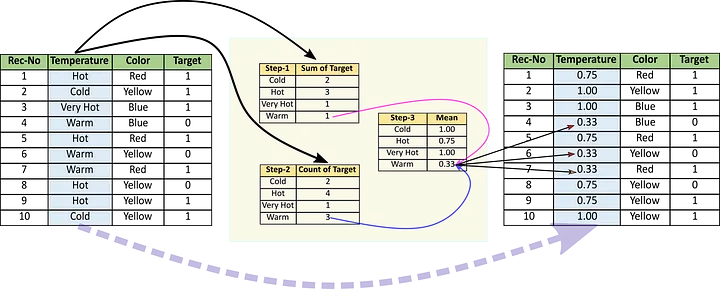
    
    * Funciona bem quando temos um variável categórica com um número de categorias muito grande
    

5. Frequency Encoding
    * Funcionamento: conta quantas vezes cada categoria apareceu e divide pelo numero total de linhas e daí o encoding é esse valor descoberto ao fazer essa divisão
    
    
6. Embedding Encoding

#### OneHotEncoding

In [282]:
#instanciando o encoder
ohe = OneHotEncoder(sparse=False)

#treinando o encoder
ohe.fit(X_train[['state_holiday']])

#aplicando o encoder nos dados de treino e gerando novo X_train
ohe_encoded_train_columns = ohe.transform(X_train[['state_holiday']])
ohe_encoded_train_dataframe = pd.DataFrame(ohe_encoded_train_columns, columns=ohe.get_feature_names_out())
ohe_encoded_train_dataframe.reset_index(drop=True, inplace=True)
X_train.reset_index(drop=True, inplace=True)
X_train = pd.concat([X_train, ohe_encoded_train_dataframe], axis=1)
X_train = X_train.drop('state_holiday', axis=1)

#aplicando o encoder nos dados de treino e gerando novo X_test
ohe_encoded_test_columns = ohe.transform(X_test[['state_holiday']])
ohe_encoded_test_dataframe = pd.DataFrame(ohe_encoded_test_columns, columns=ohe.get_feature_names_out())
ohe_encoded_test_dataframe.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
X_test = pd.concat([X_test, ohe_encoded_test_dataframe], axis=1)
X_test = X_test.drop('state_holiday', axis=1)

#### LabelEncoding

In [283]:
#store_type
le = LabelEncoder()

#treinando o encoder
le.fit(X_train[['store_type']])

#aplicando o encoder nos dados de treino e gerando nova coluna store_type
X_train['store_type'] = le.transform(X_train[['store_type']])

#aplicando o encoder nos dados de teste e gerando nova coluna store_type
X_test['store_type'] = le.transform(X_test[['store_type']])

#### OrdinalEncoding

In [284]:
#assortment
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
X_train['assortment'] = X_train['assortment'].map(assortment_dict)
X_test['assortment'] = X_test['assortment'].map(assortment_dict)

### 5.4.2 Transformação de grandeza

Trazer a variávei resposta para uma distribuição mais próxima de uma normal.

Isso é feito pois os algoritmos de ML são criados a partir de certas premissa, sendo uma delas a distribuição normal dos dados. Quanto mais próximo temos os dados perto dessas premissas, mais acurácia obtemos.

1. Transformação logarítimica (só aplicar o log)
2. Transformação Box Cox (tem uma fórmula específica)
3. Transformação Cube Root (extrair raiz cúbica)
4. Transformação Square Root (extrair raiz quadrada)
5. Transformação Seno e Cosseno

In [285]:
y_train = np.log(y_train)
y_test = np.log(y_test)

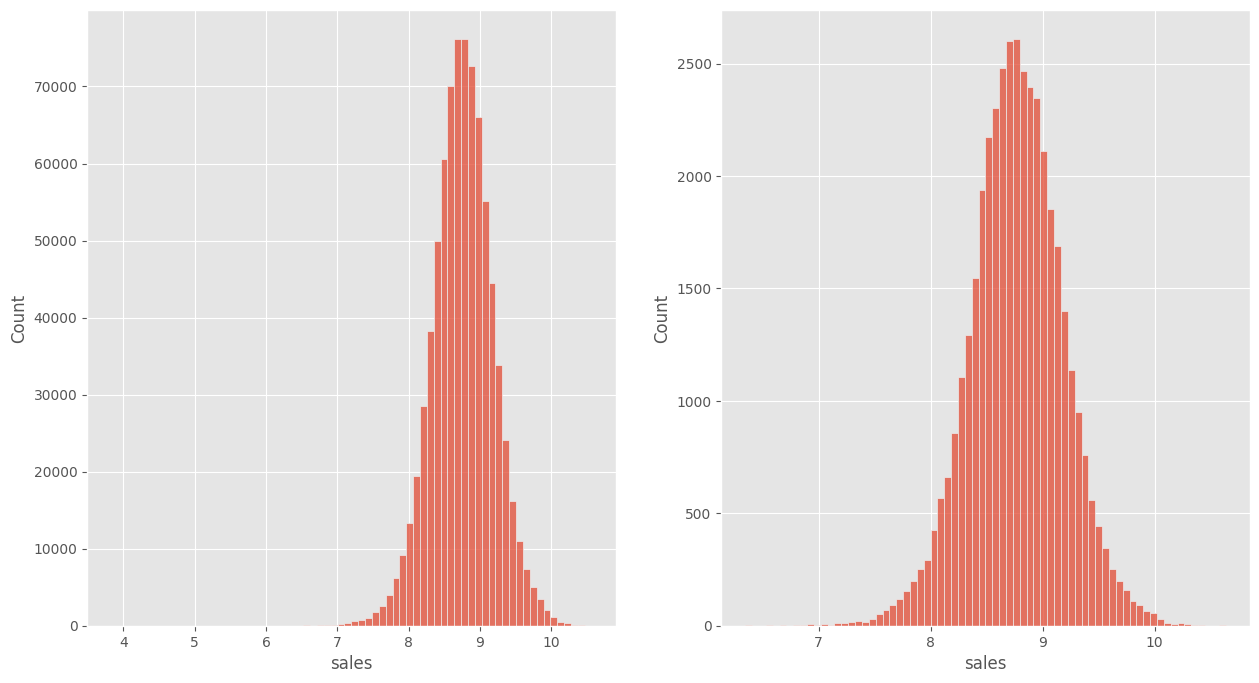

In [286]:
plt.figure(figsize=(15, 8))

plt.subplot(1, 2, 1)
sns.histplot(y_train, bins=70)

plt.subplot(1, 2, 2)
sns.histplot(y_test, bins=70)

plt.show()

### 5.4.3 Transformação de variáveis de natureza cíclica

Trazer a natureza real dos dados dentro do conjunto de dados.

Por exemplo, tomemos como base a variável mês. Temos janeiro representando o mês 1 e dezembro o mês 12. Seguindo essa escala de numéros, janeiro é perto de fevereiro (mês 2), mas muito longe de dezembro (1 está longe do 12). No entanto, quando vira o ano, dezembro que é o 12 do ano anterior é bem próximo de janeiro do ano que virou, que é 1.

Quando utiliza apenas os numéros a gente perde essa noção cíclica dessa variável.

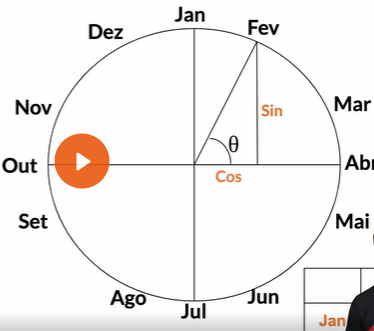

In [287]:
#month
X_train['month_sin'] = X_train['month'].apply(lambda x: np.sin(x*(2*np.pi/12)))
X_train['month_cos'] = X_train['month'].apply(lambda x: np.cos(x*(2*np.pi/12)))

X_test['month_sin'] = X_test['month'].apply(lambda x: np.sin(x*(2*np.pi/12)))
X_test['month_cos'] = X_test['month'].apply(lambda x: np.cos(x*(2*np.pi/12)))


#day
X_train['day_sin'] = X_train['day'].apply(lambda x: np.sin(x*(2*np.pi/30)))
X_train['day_cos'] = X_train['day'].apply(lambda x: np.cos(x*(2*np.pi/30)))

X_test['day_sin'] = X_test['day'].apply(lambda x: np.sin(x*(2*np.pi/30)))
X_test['day_cos'] = X_test['day'].apply(lambda x: np.cos(x*(2*np.pi/30)))


#day_of_week
X_train['day_of_week_sin'] = X_train['day_of_week'].apply(lambda x: np.sin(x*(2*np.pi/7)))
X_train['day_of_week_cos'] = X_train['day_of_week'].apply(lambda x: np.cos(x*(2*np.pi/7)))

X_test['day_of_week_sin'] = X_test['day_of_week'].apply(lambda x: np.sin(x*(2*np.pi/7)))
X_test['day_of_week_cos'] = X_test['day_of_week'].apply(lambda x: np.cos(x*(2*np.pi/7)))


#week_of_year
X_train['week_of_year_sin'] = X_train['week_of_year'].astype(int).apply(lambda x: np.sin(x*(2*np.pi/52)))
X_train['week_of_year_cos'] = X_train['week_of_year'].astype(int).apply(lambda x: np.cos(x*(2*np.pi/52)))

X_test['week_of_year_sin'] = X_test['week_of_year'].astype(int).apply(lambda x: np.sin(x*(2*np.pi/52)))
X_test['week_of_year_cos'] = X_test['week_of_year'].astype(int).apply(lambda x: np.cos(x*(2*np.pi/52)))

### 5.4.4 Excluindo colunas que não serão utilizadas

In [288]:
cols_drop = ['day_of_week', 'week_of_year', 'competition_since', 'promo_since', 'day', 'month', 'year_week']

X_train = X_train.drop(cols_drop, axis=1)
X_test = X_test.drop(cols_drop, axis=1)

# 6.0 Feature Selection

In [289]:
df6 = df5.copy()

X_train_6 = X_train.copy()
X_test_6 = X_test.copy()

### Qual é a motivação por trás dessa tarefa?

A feature selection vai de encontro a um dos príncipios da aprendizagem estatística, que é uma teoria que garante o aprendizado dos modelos. 

Esse é o princípio de Occam's Razor (Navalha de Occam's), que diz o seguinte: a explicação mais simples sobre um fenômeno observado, deveria prevalecer sobre explicações mais complexas.

Os modelos mais complexos não generalizam muito bem. Eles aprendem muito bem aqueles dados em que estão sendo treinados, mas não lida bem com dados não vistos anteriormente. 

Para tornar os modelos mais simples, precisamos remover variáveis colineares (variáveis que estão altamente correlacionadas entre si, ou seja, elas variam juntas de forma semelhante) pois elas explicam a mesma 'parte' do fenômeno que está sendo modelo, elas descrevem a mesma coisa.

### Métodos de feature selection

Todos os métodos buscam por encontrar as features mais relevantes. Mas o que é relevância no contexto de Machine Learning?
É uma medida da contribuição de cada recurso para o desempenho do modelo.

1. Seleção Univariada (Filter Methods)
    * Classifica baseado no coeficiente de correlação, que explica a intensidade da relação entre duas variáveis (quanto mais próximo de 1 ou -1, mais relevante e quanto mais próximo de 0, menos relevante)
    * Vantagens:
        * Simples
        * Rápido
        * Fácil Entendimento
    * Desvantagens:
        * Não considera a influência entre as variáveis (as vezes se olhar para uma variável preditora com a variável resposta, a correlação pode ser baixa, no entanto, essa variável preditora, combinada com outras variáveis, se torna relevante para a predição)
        
    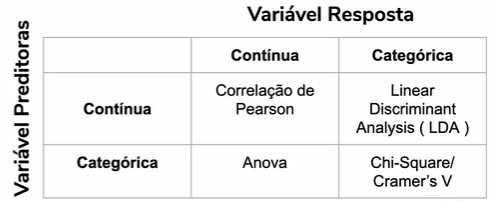
    


2. Seleção por Importância (Embedded Methods)
    * Também conhecido como método embutido (é um subproduto do sistema de aprendizado de alguns modelos - como o random forest).
    * Random Forest (Gini Impurtity) -> a variável que melhor dividiu os dados e gerou uma impureza menor é uma variável boa, relevante.
    * Da pra pegar os coeficientes da Rigde e Lasso regression também.
    
    
3. Seleção por Subset (Wrapper Methods)

### 6.1 SelectKBest

In [290]:
X_train_6 = X_train_6.drop('date', axis=1)
X_test_6 = X_test_6.drop('date', axis=1)

# seleciona as 18 melhores features usando f_classif
selector = SelectKBest(f_classif, k=18)
selector.fit(X_train_6, y_train)

#colunas selecionadas
mask = selector.get_support()
selected_cols = X_train_6.columns[mask]

#novos dados de treino e teste
X_train_new = X_train_6[selected_cols]
X_train_new['store'] = X_train_6['store']

X_test_new = X_test_6[selected_cols]
X_test_new['store'] = X_test_6['store']

### 6.2 Dados finais

In [154]:
X_train_new.head()

,promo,school_holiday,store_type,assortment,promo2,promo2_since_week,promo2_since_year,year,promo_time_week,state_holiday_christmas,state_holiday_easter holiday,state_holiday_public holiday,state_holiday_regular_day,month_cos,day_cos,day_of_week_sin,day_of_week_cos,week_of_year_cos,store
0,1,0,2,1,0,25,2015,1.0,0.293303,0.0,0.0,0.0,1.0,-1.0,-0.809017,-0.433884,-0.900969,-0.970942,1
1,1,0,0,1,1,13,2010,1.0,0.921478,0.0,0.0,0.0,1.0,-1.0,-0.809017,-0.433884,-0.900969,-0.970942,2
2,1,0,0,1,1,14,2011,1.0,0.799076,0.0,0.0,0.0,1.0,-1.0,-0.809017,-0.433884,-0.900969,-0.970942,3
3,1,0,2,3,0,25,2015,1.0,0.293303,0.0,0.0,0.0,1.0,-1.0,-0.809017,-0.433884,-0.900969,-0.970942,4
4,1,0,0,1,0,25,2015,1.0,0.293303,0.0,0.0,0.0,1.0,-1.0,-0.809017,-0.433884,-0.900969,-0.970942,5


In [155]:
X_test_new.head()

,promo,school_holiday,store_type,assortment,promo2,promo2_since_week,promo2_since_year,year,promo_time_week,state_holiday_christmas,state_holiday_easter holiday,state_holiday_public holiday,state_holiday_regular_day,month_cos,day_cos,day_of_week_sin,day_of_week_cos,week_of_year_cos,store
0,1,1,2,1,0,31,2015,1.0,0.293303,0.0,0.0,0.0,1.0,-0.866025,0.978148,-0.974928,-0.222521,-0.885456,1
1,1,1,0,1,1,13,2010,1.0,0.935335,0.0,0.0,0.0,1.0,-0.866025,0.978148,-0.974928,-0.222521,-0.885456,2
2,1,1,0,1,1,14,2011,1.0,0.812933,0.0,0.0,0.0,1.0,-0.866025,0.978148,-0.974928,-0.222521,-0.885456,3
3,1,1,2,3,0,31,2015,1.0,0.293303,0.0,0.0,0.0,1.0,-0.866025,0.978148,-0.974928,-0.222521,-0.885456,4
4,1,1,0,1,0,31,2015,1.0,0.293303,0.0,0.0,0.0,1.0,-0.866025,0.978148,-0.974928,-0.222521,-0.885456,5


In [156]:
y_train.reset_index(drop=True, inplace=True)
y_train

0         8.443547
1         8.547528
2         8.927580
3         9.091557
4         8.501876
            ...   
802937    8.124151
802938    9.284055
802939    8.524169
802940    8.409831
802941    8.692994
Name: sales, Length: 802942, dtype: float64

In [157]:
y_test

0        8.568456
1        8.710125
2        9.025696
3        9.546455
4        8.480944
           ...   
47940    8.633731
47941    9.327234
47942    8.869820
47943    9.991224
47944    9.022926
Name: sales, Length: 41396, dtype: float64

# 7.0 Modelos de Machine Learning

Um modelos de machine learning basicamente tem como função aprender o comportamento de um fenômeno (no caso, vendas) com as variáveis disponíveis e então generalizá-lo para o futuro.

Nossos dados de treino são:
* X_train_new
* y_train

E os de teste são:
* X_test_new
* y_test

In [377]:
X_train_cv = X_train_new.copy()
X_train_cv['date'] = X_train['date']
X_train_cv['sales'] = y_train.reset_index(drop=True)

### 7.1 Average Model

O intuito desse modelo não é nem servir como ferramenta para a previsão das vendas em si, mas sim como um meio para comparar a perfomance dos outros modelos

In [238]:
#copiando os dados de treino e adicionando a coluna sales (tirando fora o log)
aux1 = X_train_new.copy()
aux1['sales'] = np.expm1(y_train)

#média de vendas por loja nos dados de treino
predictions = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales':'predictions'})

#preve a venda das lojas com a média de vendas por loja encontrada nos dados de treino
aux2 = X_test_new.copy()
aux2['sales'] = np.expm1(y_test).reset_index(drop=True)
aux2 = aux2[['store', 'sales']]
aux2['predictions'] = aux2.apply(lambda x: float(predictions[predictions['store'] == x['store']]['predictions']), axis=1)

#perfomance
avg_model_metrics = ml_error('Average Model', aux2['sales'], aux2['predictions'])
avg_model_metrics

,Model Name,MAE,MAPE,RMSE
0,Average Model,1440.360095,0.22777,1916.544163


### 7.2 Linear Regression

In [239]:
#model
lr = LinearRegression().fit(X_train_new, y_train)

#predict
ypred_lr = lr.predict(X_test_new)

#perfomance
lr_metrics = ml_error('Linear Regression', np.expm1(y_test), np.expm1(ypred_lr))
lr_metrics

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1871.356525,0.293903,2681.906495


#### 7.2.1 Linear Regression - CV

In [379]:
lr_metrics_cv = cross_validation('LinearRegression', LinearRegression(), X_train_cv, 5)
lr_metrics_cv

KFold: 5
KFold: 4
KFold: 3
KFold: 2
KFold: 1


,MAE,MAPE,RMSE,Model
0,2055.12 +/- 278.63,0.29 +/- 0.01,2946.91 +/- 416.12,LinearRegression


### 7.3 Linear Regression Regularized

In [240]:
#model
lasso = Lasso(alpha=0.01).fit(X_train_new, y_train)

#predict
ypred_lasso = lasso.predict(X_test_new)

#perfomance
lasso_metrics = ml_error('Lasso', np.expm1(y_test), np.expm1(ypred_lasso))
lasso_metrics

,Model Name,MAE,MAPE,RMSE
0,Lasso,1891.796446,0.290523,2744.198218


#### 7.3.1 Linear Regression Regularized - CV

In [381]:
lasso_metrics_cv = cross_validation('Lasso', Lasso(alpha=0.01), X_train_cv, 5)
lasso_metrics_cv

KFold: 5
KFold: 4
KFold: 3
KFold: 2
KFold: 1


,MAE,MAPE,RMSE,Model
0,2120.18 +/- 339.23,0.29 +/- 0.01,3064.98 +/- 500.52,Lasso


### 7.4 Random Forest Regressor

In [243]:
#model
rf = RandomForestRegressor(n_estimators=70, n_jobs=-1, random_state=42).fit(X_train_new, y_train)

#predict
ypred_rf = rf.predict(X_test_new)

#perfomance
rf_metrics = ml_error('Random Forest', np.expm1(y_test), np.expm1(ypred_rf))
rf_metrics

#### 7.4.1 Random Forest Regressor - CV

In [ ]:
rf_metrics_cv = cross_validation('Random Forest', RandomForestRegressor(), X_train_cv, 5)
rf_metrics_cv

KFold: 5
KFold: 4


### 7.5 XGBoost Regressor

In [268]:
#model
xgb = xgb.XGBRegressor().fit(X_train_new, y_train)

#predict
ypred_xgb = xgb.predict(X_test_new)

#perfomance
xgb_metrics = ml_error('XGBoost', np.expm1(y_test), np.expm1(ypred_xgb))
xgb_metrics

#### 7.5.1 XGBoost Regressor - CV

In [ ]:
xgb_metrics_cv = cross_validation('XGBoost Regressor', xgb.XGBRegressor(), X_train_cv, 5)
xgb_metrics_cv

### 7.6 Compare Model's Perfomance

#### 7.6.1 Single Fold Perfomance

In [270]:
modelling_result = pd.concat([avg_model_metrics, lr_metrics, lasso_metrics, rf_metrics, xgb_metrics])
modelling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest,702.904456,0.106226,1024.194037
0,XGBoost,1000.539198,0.153708,1418.148567
0,Average Model,1440.360095,0.227770,1916.544163
0,Linear Regression,1871.356525,0.293903,2681.906495
0,Lasso,1891.796446,0.290523,2744.198218


#### 7.6.2 Cross Validation Perfomance

In [ ]:
modelling_result_cv = pd.concat([avg_model_metrics, lr_metrics_cv, lasso_metrics_cv, rf_metrics_cv, xgb_metrics_cv])
modelling_result_cv